cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:06<00:00,  8.05it/s]


saving model version 0.1


ValueError: Input contains NaN.

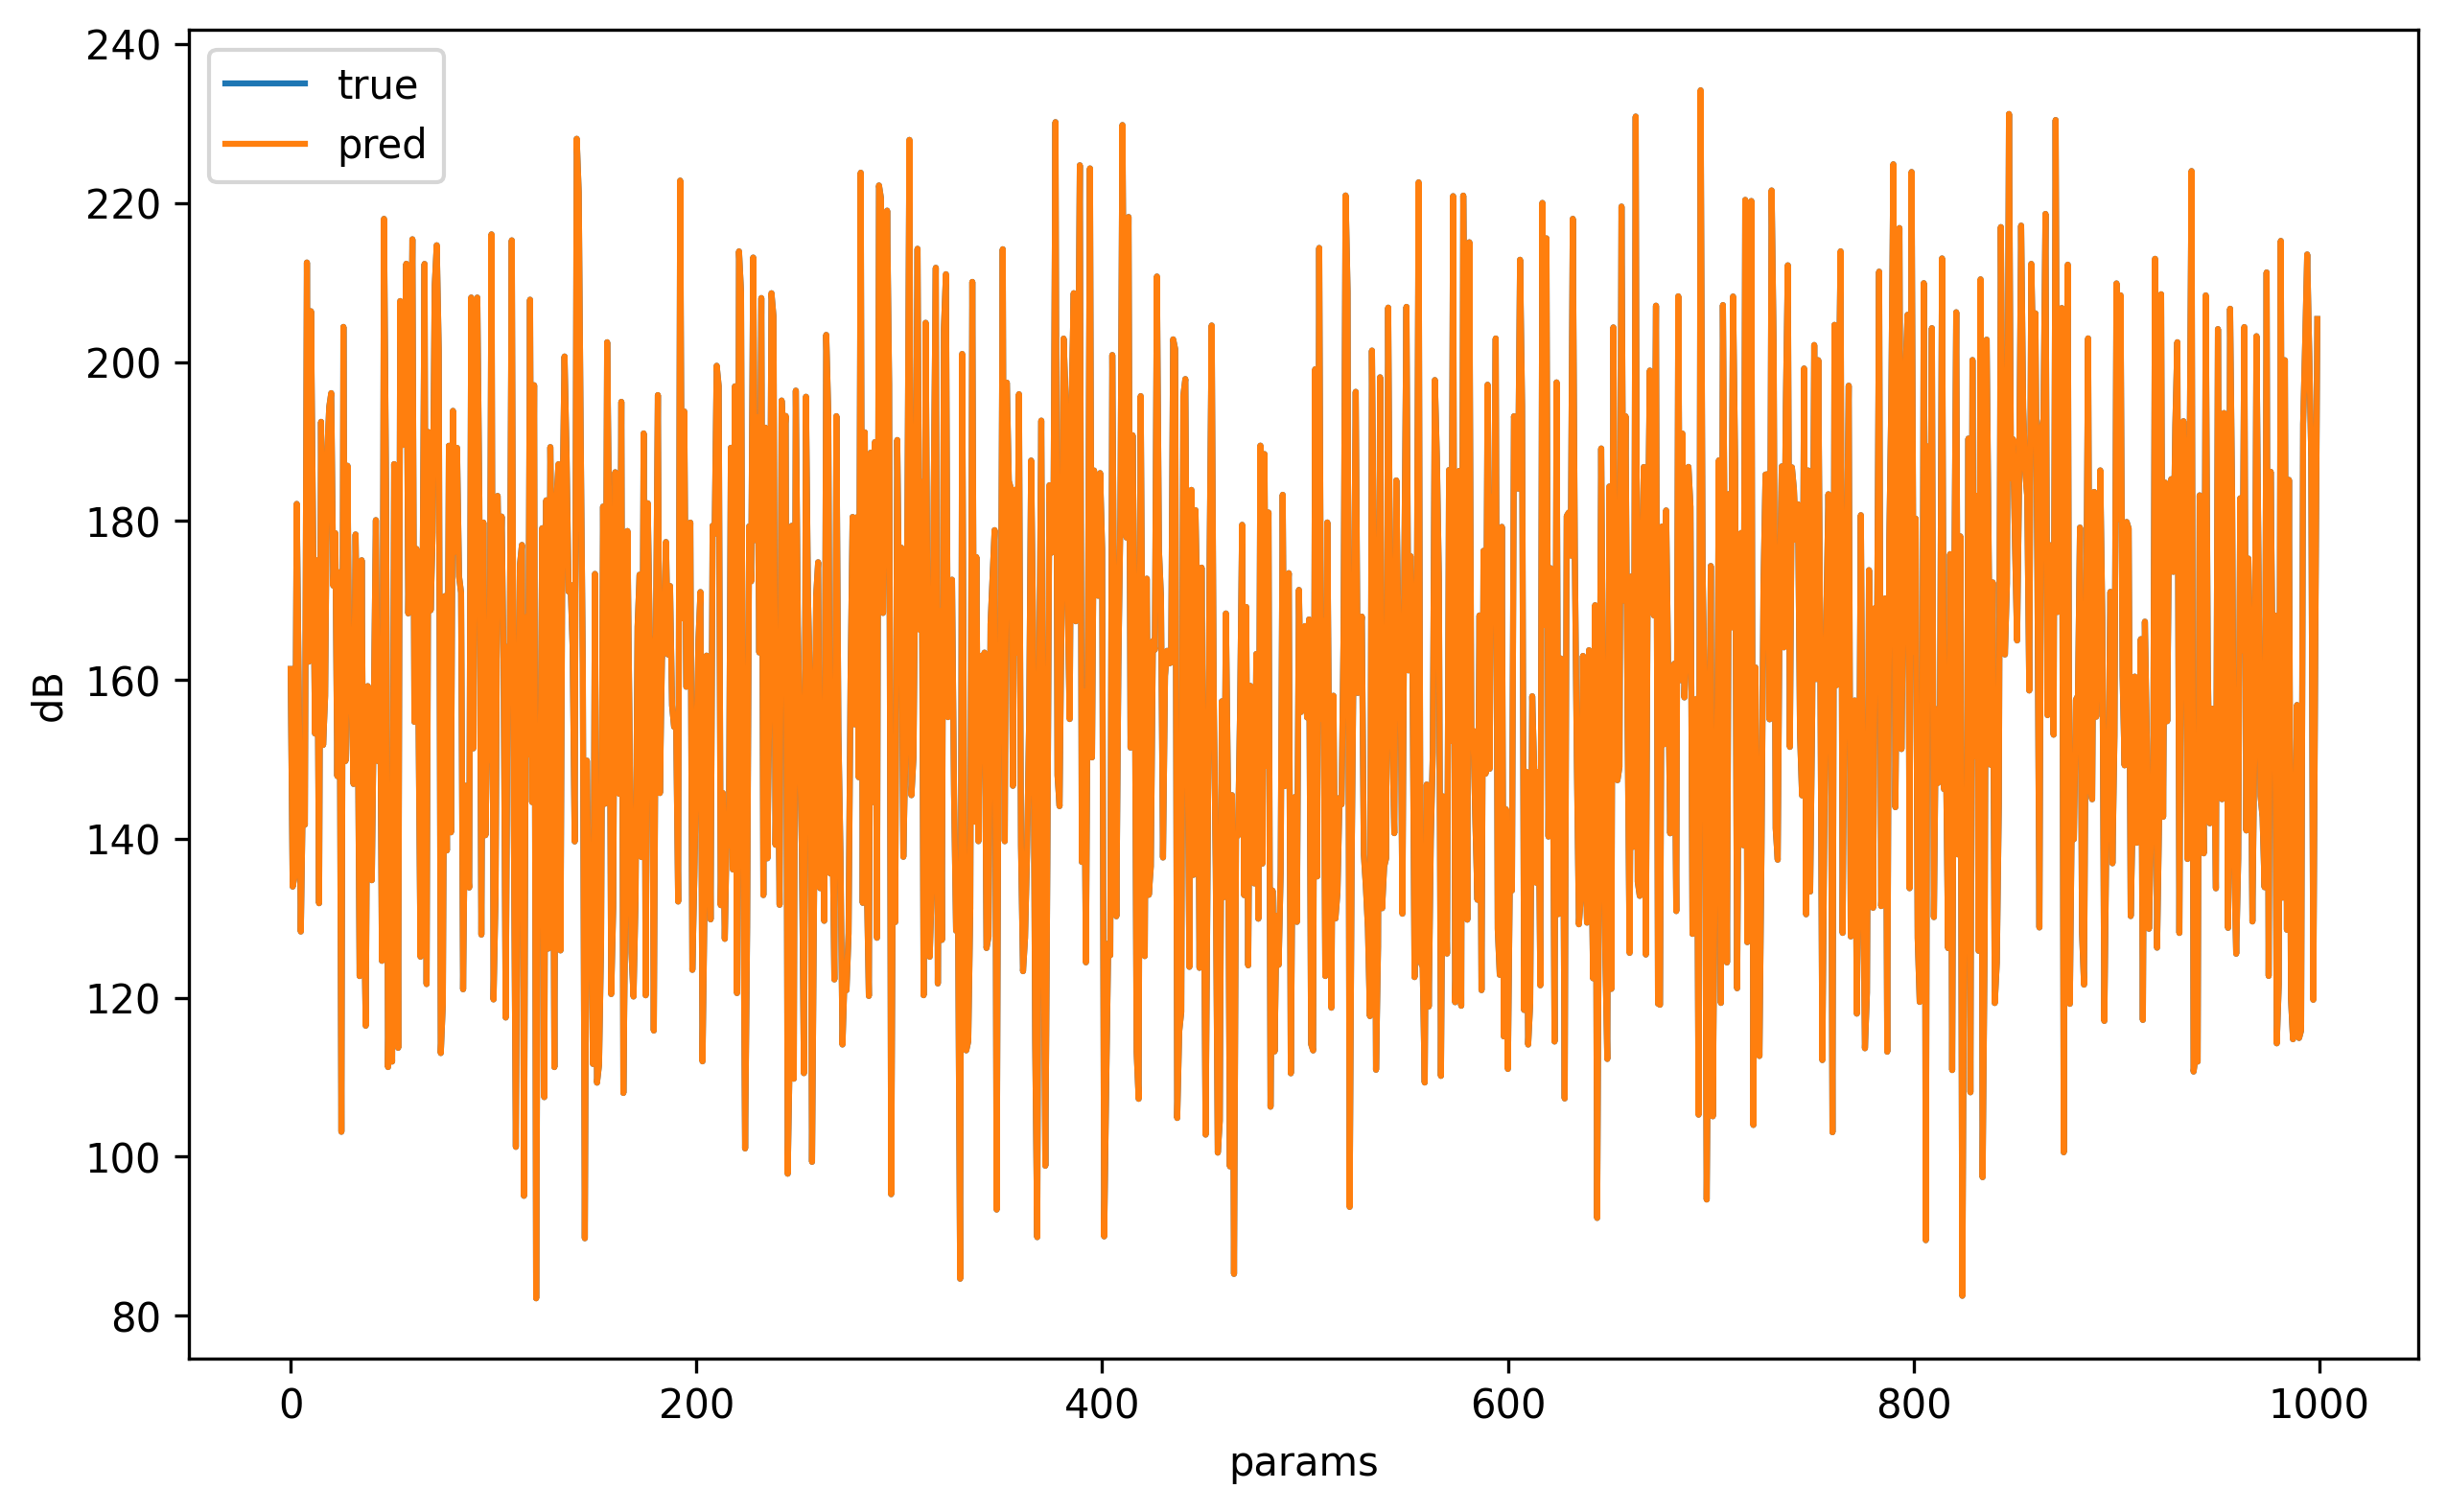

In [ ]:

from kan import *
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from scipy import constants

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    plt.legend(['true', 'pred'])
    plt.ylabel('PL values computed vs predicted [dB]')
    plt.xlabel('params')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label=metric_name)
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


f = lambda x: 20 * torch.log10((4 * torch.pi * x[:,[0]]) / constants.c) + 10 * x[:,[1]] * torch.log10(x[:,[2]]) + x[:,[3]]
dataset = create_dataset(f, 
                         n_var=4, 
                         ranges=[(2000000000,73000000000), (2, 6), (1, 500), (4,12) ], 
                         #train_num=5000,
                         device=device)

time = range(len(dataset['test_label']))
plt.plot(time, dataset['test_label'])
plt.legend(['true'])
plt.ylabel('dB')
plt.xlabel('params')

model = KAN(width=[4,2,2,1], grid=5, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=50, lamb=0.02, lamb_entropy=2.);

eval_kan(model, dataset)
model.plot()

model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)


In [ ]:

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.);
eval_kan(model, dataset)

formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.24e+01 | test_loss: 1.19e+01 | reg: 1.21e+02 | :   4%| | 13/300 [00:02<00:47,  5.99i


KeyboardInterrupt: 

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[4, 2, 2, 1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 5.26e+00 | test_loss: 5.15e+00 | reg: 6.64e+01 | : 100%|█| 100/100 [00:15<00:00,  6.37


saving model version 0.1
MSE: 26.4835
RMSE: 5.1462
MAE: 3.1430
MAPE: 14.0764
R²: 0.9950
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 6.90e+00 | test_loss: 6.20e+00 | reg: 6.37e+01 | : 100%|█| 100/100 [00:16<00:00,  6.13


saving model version 0.1
MSE: 38.3858
RMSE: 6.1956
MAE: 4.0153
MAPE: 21.7685
R²: 0.9928
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 1.12e+01 | test_loss: 1.14e+01 | reg: 2.82e+02 | : 100%|█| 100/100 [00:11<00:00,  8.76


saving model version 0.1
MSE: 129.0692
RMSE: 11.3609
MAE: 8.7638
MAPE: 61.8006
R²: 0.9758
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 2.89e+01 | test_loss: 2.73e+01 | reg: 6.00e+03 | : 100%|█| 100/100 [00:14<00:00,  7.08


saving model version 0.1
MSE: 747.8029
RMSE: 27.3460
MAE: 21.3732
MAPE: 178.1671
R²: 0.8600
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 4.33e+00 | test_loss: 4.28e+00 | reg: 7.22e+01 | : 100%|█| 200/200 [00:36<00:00,  5.48


saving model version 0.1
MSE: 18.2840
RMSE: 4.2760
MAE: 2.5331
MAPE: 8.6905
R²: 0.9966
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 5.96e+00 | test_loss: 5.51e+00 | reg: 6.15e+01 | : 100%|█| 200/200 [00:38<00:00,  5.24


saving model version 0.1
MSE: 30.4098
RMSE: 5.5145
MAE: 3.2467
MAPE: 12.8933
R²: 0.9943
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 1.11e+01 | test_loss: 1.13e+01 | reg: 2.82e+02 | : 100%|█| 200/200 [00:19<00:00, 10.27


saving model version 0.1
MSE: 126.7000
RMSE: 11.2561
MAE: 8.6782
MAPE: 64.1233
R²: 0.9763
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 2.81e+01 | test_loss: 2.64e+01 | reg: 6.00e+03 | : 100%|█| 200/200 [00:25<00:00,  7.96


saving model version 0.1
MSE: 699.4117
RMSE: 26.4464
MAE: 20.7882
MAPE: 193.9401
R²: 0.8691
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 3.51e+00 | test_loss: 3.52e+00 | reg: 7.68e+01 | : 100%|█| 300/300 [00:55<00:00,  5.41


saving model version 0.1
MSE: 12.4052
RMSE: 3.5221
MAE: 2.0968
MAPE: 7.5603
R²: 0.9977
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 5.62e+00 | test_loss: 5.25e+00 | reg: 6.11e+01 | : 100%|█| 300/300 [00:52<00:00,  5.73


saving model version 0.1
MSE: 27.5142
RMSE: 5.2454
MAE: 3.0146
MAPE: 10.2031
R²: 0.9948
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 1.07e+01 | test_loss: 1.09e+01 | reg: 2.81e+02 | : 100%|█| 300/300 [00:32<00:00,  9.21


saving model version 0.1
MSE: 117.7861
RMSE: 10.8529
MAE: 8.2003
MAPE: 63.6084
R²: 0.9780
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 2.78e+01 | test_loss: 2.62e+01 | reg: 6.00e+03 | : 100%|█| 300/300 [00:41<00:00,  7.22


saving model version 0.1
MSE: 685.8652
RMSE: 26.1890
MAE: 20.5869
MAPE: 191.3432
R²: 0.8716
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 2.90e+00 | test_loss: 3.70e+00 | reg: 1.59e+02 | : 100%|█| 100/100 [00:23<00:00,  4.29


saving model version 0.1
MSE: 13.6603
RMSE: 3.6960
MAE: 2.3262
MAPE: 13.1658
R²: 0.9974
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 4.17e+00 | test_loss: 4.14e+00 | reg: 1.85e+02 | : 100%|█| 100/100 [00:23<00:00,  4.28


saving model version 0.1
MSE: 17.1628
RMSE: 4.1428
MAE: 2.8061
MAPE: 16.4538
R²: 0.9968
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 3.48e+00 | test_loss: 3.64e+00 | reg: 1.72e+02 | : 100%|█| 100/100 [00:23<00:00,  4.25


saving model version 0.1
MSE: 13.2672
RMSE: 3.6424
MAE: 1.8956
MAPE: 9.2942
R²: 0.9975
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 3.08e+00 | test_loss: 3.77e+00 | reg: 2.77e+02 | : 100%|█| 100/100 [00:23<00:00,  4.34


saving model version 0.1
MSE: 14.1827
RMSE: 3.7660
MAE: 2.3965
MAPE: 8.4729
R²: 0.9973
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 2.25e+00 | test_loss: 3.41e+00 | reg: 1.48e+02 | : 100%|█| 200/200 [00:48<00:00,  4.15


saving model version 0.1
MSE: 11.6231
RMSE: 3.4093
MAE: 1.9993
MAPE: 9.9353
R²: 0.9978
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 2.58e+00 | test_loss: 2.99e+00 | reg: 2.01e+02 | : 100%|█| 200/200 [00:45<00:00,  4.38


saving model version 0.1
MSE: 8.9380
RMSE: 2.9896
MAE: 1.7747
MAPE: 8.7042
R²: 0.9983
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 2.05e+00 | test_loss: 2.85e+00 | reg: 1.80e+02 | : 100%|█| 200/200 [00:46<00:00,  4.32


saving model version 0.1
MSE: 8.1141
RMSE: 2.8485
MAE: 1.5266
MAPE: 8.3996
R²: 0.9985
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 2.04e+00 | test_loss: 9.18e+00 | reg: 2.92e+02 | : 100%|█| 200/200 [00:47<00:00,  4.19


saving model version 0.1
MSE: 84.3596
RMSE: 9.1847
MAE: 1.8084
MAPE: 7.4162
R²: 0.9842
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 1.76e+00 | test_loss: 2.49e+00 | reg: 1.35e+02 | : 100%|█| 300/300 [11:16<00:00,  2.26


saving model version 0.1
MSE: 6.2125
RMSE: 2.4925
MAE: 1.5640
MAPE: 8.0543
R²: 0.9988
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 2.05e+00 | test_loss: 2.75e+00 | reg: 2.02e+02 | : 100%|█| 300/300 [16:45<00:00,  3.35


saving model version 0.1
MSE: 7.5376
RMSE: 2.7455
MAE: 1.5709
MAPE: 8.0154
R²: 0.9986
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 1.53e+00 | test_loss: 2.14e+00 | reg: 1.87e+02 | : 100%|█| 300/300 [17:16<00:00,  3.45


saving model version 0.1
MSE: 4.5836
RMSE: 2.1409
MAE: 1.1841
MAPE: 5.6559
R²: 0.9991
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 1.83e+00 | test_loss: 9.06e+00 | reg: 2.89e+02 | : 100%|█| 300/300 [01:03<00:00,  4.72


saving model version 0.1
MSE: 82.0849
RMSE: 9.0601
MAE: 1.6163
MAPE: 5.5521
R²: 0.9846
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 2.74e+01 | test_loss: 2.80e+01 | reg: 5.04e+01 | : 100%|█| 100/100 [00:09<00:00, 10.76


saving model version 0.1
MSE: 784.2590
RMSE: 28.0046
MAE: 18.2862
MAPE: 77.6629
R²: 0.8532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:22<00:00,  4.40it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 2.39e+01 | test_loss: 2.22e+01 | reg: 9.99e+02 | : 100%|█| 100/100 [15:33<00:00,  9.34


saving model version 0.1
MSE: 492.0218
RMSE: 22.1816
MAE: 15.6886
MAPE: 62.3708
R²: 0.9079
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 2.94e+01 | test_loss: 2.94e+01 | reg: 1.06e+03 | : 100%|█| 100/100 [00:10<00:00,  9.56


saving model version 0.1
MSE: 865.2902
RMSE: 29.4158
MAE: 21.4531
MAPE: 72.4600
R²: 0.8380
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 2.74e+01 | test_loss: 2.80e+01 | reg: 5.04e+01 | : 100%|█| 200/200 [00:15<00:00, 12.89


saving model version 0.1
MSE: 784.2590
RMSE: 28.0046
MAE: 18.2862
MAPE: 77.6629
R²: 0.8532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [16:32<00:00,  4.96s/it]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 2.39e+01 | test_loss: 2.22e+01 | reg: 9.99e+02 | : 100%|█| 200/200 [00:16<00:00, 11.97


saving model version 0.1
MSE: 492.0220
RMSE: 22.1816
MAE: 15.6886
MAPE: 62.3707
R²: 0.9079
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-05


| train_loss: 2.94e+01 | test_loss: 2.94e+01 | reg: 1.06e+03 | : 100%|█| 200/200 [16:29<00:00,  4.95


saving model version 0.1
MSE: 865.2902
RMSE: 29.4158
MAE: 21.4531
MAPE: 72.4600
R²: 0.8380
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.02


| train_loss: 2.74e+01 | test_loss: 2.80e+01 | reg: 5.04e+01 | : 100%|█| 300/300 [00:23<00:00, 12.55


saving model version 0.1
MSE: 784.2590
RMSE: 28.0046
MAE: 18.2862
MAPE: 77.6629
R²: 0.8532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.002


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 300/300 [16:17<00:00,  3.26s/it]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.0002


| train_loss: 2.39e+01 | test_loss: 2.22e+01 | reg: 9.99e+02 | : 100%|█| 300/300 [00:23<00:00, 12.71


saving model version 0.1
MSE: 492.0220
RMSE: 22.1816
MAE: 15.6886
MAPE: 62.3707
R²: 0.9079
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 2e-05


| train_loss: 2.94e+01 | test_loss: 2.94e+01 | reg: 1.06e+03 | : 100%|█| 300/300 [00:23<00:00, 12.87


saving model version 0.1
MSE: 865.3317
RMSE: 29.4165
MAE: 21.4522
MAPE: 72.4291
R²: 0.8380
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.02


| train_loss: 5.99e+01 | test_loss: 6.32e+01 | reg: 3.53e+02 | : 100%|█| 100/100 [00:23<00:00,  4.24


saving model version 0.1
MSE: 3992.8311
RMSE: 63.1889
MAE: 53.0375
MAPE: 288.8219
R²: 0.2526
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.002


| train_loss: 2.54e+01 | test_loss: 2.43e+01 | reg: 8.87e+03 | : 100%|█| 100/100 [04:21<00:00,  2.61


saving model version 0.1
MSE: 588.9894
RMSE: 24.2691
MAE: 17.8572
MAPE: 90.6877
R²: 0.8898
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.0002


| train_loss: 7.15e+01 | test_loss: 7.24e+01 | reg: 3.72e+03 | : 100%|█| 100/100 [00:20<00:00,  4.89


saving model version 0.1
MSE: 5238.0659
RMSE: 72.3745
MAE: 60.4578
MAPE: 395.2934
R²: 0.0195
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 2e-05


| train_loss: 7.11e+01 | test_loss: 7.19e+01 | reg: 3.98e+03 | : 100%|█| 100/100 [17:54<00:00, 10.74


saving model version 0.1
MSE: 5166.7861
RMSE: 71.8804
MAE: 60.4512
MAPE: 371.4631
R²: 0.0329
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.02


| train_loss: 5.97e+01 | test_loss: 6.31e+01 | reg: 3.50e+02 | : 100%|█| 200/200 [00:41<00:00,  4.83


saving model version 0.1
MSE: 3987.2744
RMSE: 63.1449
MAE: 52.9510
MAPE: 280.9112
R²: 0.2536
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.002


| train_loss: 2.39e+01 | test_loss: 2.30e+01 | reg: 8.70e+03 | : 100%|█| 200/200 [01:09<00:00,  2.89


saving model version 0.1
MSE: 527.3207
RMSE: 22.9635
MAE: 16.1097
MAPE: 98.6132
R²: 0.9013
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.0002


| train_loss: 7.13e+01 | test_loss: 7.23e+01 | reg: 3.69e+03 | : 100%|█| 200/200 [16:15<00:00,  4.88


saving model version 0.1
MSE: 5228.1367
RMSE: 72.3059
MAE: 60.4072
MAPE: 389.4936
R²: 0.0214
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 2e-05


| train_loss: 7.10e+01 | test_loss: 7.21e+01 | reg: 4.08e+03 | : 100%|█| 200/200 [00:39<00:00,  5.01


saving model version 0.1
MSE: 5195.1152
RMSE: 72.0771
MAE: 60.5562
MAPE: 371.4560
R²: 0.0276
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.02


| train_loss: 5.97e+01 | test_loss: 6.31e+01 | reg: 3.49e+02 | : 100%|█| 300/300 [01:04<00:00,  4.68


saving model version 0.1
MSE: 3987.1909
RMSE: 63.1442
MAE: 52.9944
MAPE: 275.9085
R²: 0.2537
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.002


| train_loss: 2.39e+01 | test_loss: 2.30e+01 | reg: 8.70e+03 | : 100%|█| 300/300 [16:49<00:00,  3.36


saving model version 0.1
MSE: 527.3207
RMSE: 22.9635
MAE: 16.1097
MAPE: 98.6143
R²: 0.9013
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.0

| train_loss: 7.13e+01 | test_loss: 7.23e+01 | reg: 3.69e+03 | : 100%|█| 300/300 [00:48<00:00,  6.21


saving model version 0.1
MSE: 5228.2319
RMSE: 72.3065
MAE: 60.4090
MAPE: 389.3414
R²: 0.0214
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid si

| train_loss: 7.10e+01 | test_loss: 7.21e+01 | reg: 4.08e+03 | : 100%|█| 300/300 [17:09<00:00,  3.43


saving model version 0.1
MSE: 5194.1064
RMSE: 72.0701
MAE: 60.5371
MAPE: 372.2709
R²: 0.0277
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model 

| train_loss: 6.14e+01 | test_loss: 6.71e+01 | reg: 8.29e+01 | : 100%|█| 100/100 [16:33<00:00,  9.94


saving model version 0.1
MSE: 4507.3335
RMSE: 67.1367
MAE: 55.4905
MAPE: 374.3271
R²: 0.1563
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./m

| train_loss: 6.09e+01 | test_loss: 6.77e+01 | reg: 7.81e+01 | : 100%|█| 100/100 [00:42<00:00,  2.34


saving model version 0.1
MSE: 4577.5552
RMSE: 67.6576
MAE: 55.8816
MAPE: 403.0888
R²: 0.1432
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint dir

| train_loss: 6.38e+01 | test_loss: 6.65e+01 | reg: 2.72e+02 | : 100%|█| 100/100 [00:33<00:00,  3.01


saving model version 0.1
MSE: 4418.8901
RMSE: 66.4747
MAE: 55.7616
MAPE: 275.0208
R²: 0.1729
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.20e+01 | test_loss: 6.47e+01 | reg: 1.56e+02 | : 100%|█| 100/100 [00:40<00:00,  2.50


saving model version 0.1
MSE: 4184.4224
RMSE: 64.6871
MAE: 53.8344
MAPE: 342.4673
R²: 0.2167
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.06e+01 | test_loss: 6.84e+01 | reg: 8.16e+01 | : 100%|█| 200/200 [16:52<00:00,  5.06


saving model version 0.1
MSE: 4683.3154
RMSE: 68.4348
MAE: 55.8563
MAPE: 398.8809
R²: 0.1234
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.86e+01 | test_loss: 6.86e+01 | reg: 8.38e+01 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
MSE: 4702.6821
RMSE: 68.5761
MAE: 56.4828
MAPE: 370.9983
R²: 0.1197
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.38e+01 | test_loss: 6.65e+01 | reg: 2.70e+02 | : 100%|█| 200/200 [00:32<00:00,  6.25


saving model version 0.1
MSE: 4418.2163
RMSE: 66.4697
MAE: 55.7801
MAPE: 272.1495
R²: 0.1730
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.12e+01 | test_loss: 6.48e+01 | reg: 1.80e+02 | : 100%|█| 200/200 [17:33<00:00,  5.27


saving model version 0.1
MSE: 4197.9648
RMSE: 64.7917
MAE: 54.1863
MAPE: 355.5712
R²: 0.2142
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.03e+01 | test_loss: 6.85e+01 | reg: 8.15e+01 | : 100%|█| 300/300 [01:21<00:00,  3.69


saving model version 0.1
MSE: 4697.2402
RMSE: 68.5364
MAE: 55.8248
MAPE: 384.8251
R²: 0.1208
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.68e+01 | test_loss: 6.88e+01 | reg: 8.78e+01 | : 100%|█| 300/300 [16:44<00:00,  3.35


saving model version 0.1
MSE: 4735.5908
RMSE: 68.8156
MAE: 56.4446
MAPE: 354.5852
R²: 0.1136
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.35e+01 | test_loss: 6.65e+01 | reg: 2.71e+02 | : 100%|█| 300/300 [00:43<00:00,  6.91


saving model version 0.1
MSE: 4417.0781
RMSE: 66.4611
MAE: 55.8095
MAPE: 300.4827
R²: 0.1732
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 6.08e+01 | test_loss: 6.54e+01 | reg: 1.91e+02 | : 100%|█| 300/300 [09:10<00:00,  1.84


saving model version 0.1
MSE: 4277.2153
RMSE: 65.4004
MAE: 54.7437
MAPE: 379.2816
R²: 0.1994
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.39e+01 | test_loss: 6.73e+01 | reg: 4.94e+02 | : 100%|█| 100/100 [00:26<00:00,  3.71


saving model version 0.1
MSE: 4526.8140
RMSE: 67.2816
MAE: 55.8677
MAPE: 268.0359
R²: 0.1527
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.58e+01 | test_loss: 6.88e+01 | reg: 5.10e+02 | : 100%|█| 100/100 [09:29<00:00,  5.69


saving model version 0.1
MSE: 4733.1582
RMSE: 68.7980
MAE: 56.7183
MAPE: 339.2430
R²: 0.1140
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.76e+01 | test_loss: 6.41e+01 | reg: 4.88e+01 | : 100%|█| 100/100 [00:28<00:00,  3.47


saving model version 0.1
MSE: 4103.9331
RMSE: 64.0619
MAE: 53.5657
MAPE: 279.1584
R²: 0.2318
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.83e+01 | test_loss: 6.47e+01 | reg: 5.34e+02 | : 100%|█| 100/100 [16:02<00:00,  9.62


saving model version 0.1
MSE: 4187.0566
RMSE: 64.7075
MAE: 54.4980
MAPE: 242.7252
R²: 0.2162
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.12e+01 | test_loss: 6.84e+01 | reg: 5.26e+02 | : 100%|█| 200/200 [17:18<00:00,  5.19


saving model version 0.1
MSE: 4679.6768
RMSE: 68.4082
MAE: 56.4150
MAPE: 276.4660
R²: 0.1240
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.39e+01 | test_loss: 6.90e+01 | reg: 5.30e+02 | : 100%|█| 200/200 [16:42<00:00,  5.01


saving model version 0.1
MSE: 4762.2861
RMSE: 69.0093
MAE: 56.7200
MAPE: 388.3108
R²: 0.1086
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.67e+01 | test_loss: 6.42e+01 | reg: 4.82e+01 | : 100%|█| 200/200 [16:06<00:00,  4.83


saving model version 0.1
MSE: 4127.1685
RMSE: 64.2430
MAE: 53.4436
MAPE: 317.5151
R²: 0.2275
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.72e+01 | test_loss: 6.44e+01 | reg: 5.28e+02 | : 100%|█| 200/200 [05:23<00:00,  1.62


saving model version 0.1
MSE: 4146.8540
RMSE: 64.3961
MAE: 54.0417
MAPE: 259.6011
R²: 0.2238
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.04e+01 | test_loss: 6.88e+01 | reg: 5.29e+02 | : 100%|█| 300/300 [17:28<00:00,  3.50


saving model version 0.1
MSE: 4732.2881
RMSE: 68.7916
MAE: 56.3890
MAPE: 254.7040
R²: 0.1142
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.00e+01 | test_loss: 7.24e+01 | reg: 6.18e+02 | : 100%|█| 300/300 [01:45<00:00,  2.83


saving model version 0.1
MSE: 5240.2065
RMSE: 72.3893
MAE: 59.0854
MAPE: 384.8758
R²: 0.0191
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.56e+01 | test_loss: 6.49e+01 | reg: 4.77e+01 | : 100%|█| 300/300 [19:10<00:00,  3.83


saving model version 0.1
MSE: 4212.5142
RMSE: 64.9039
MAE: 53.8388
MAPE: 293.6513
R²: 0.2115
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.63e+01 | test_loss: 6.47e+01 | reg: 5.21e+02 | : 100%|█| 300/300 [16:36<00:00,  3.32


saving model version 0.1
MSE: 4183.5498
RMSE: 64.6804
MAE: 54.3361
MAPE: 279.5926
R²: 0.2169
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.85e+01 | test_loss: 6.79e+01 | reg: 1.09e+02 | : 100%|█| 100/100 [15:31<00:00,  9.32


saving model version 0.1
MSE: 4611.8970
RMSE: 67.9109
MAE: 56.1036
MAPE: 214.8517
R²: 0.1367
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0

| train_loss: 5.16e+01 | test_loss: 5.80e+01 | reg: 8.17e+01 | :  97%|▉| 97/100 [16:36<14:31, 290.52

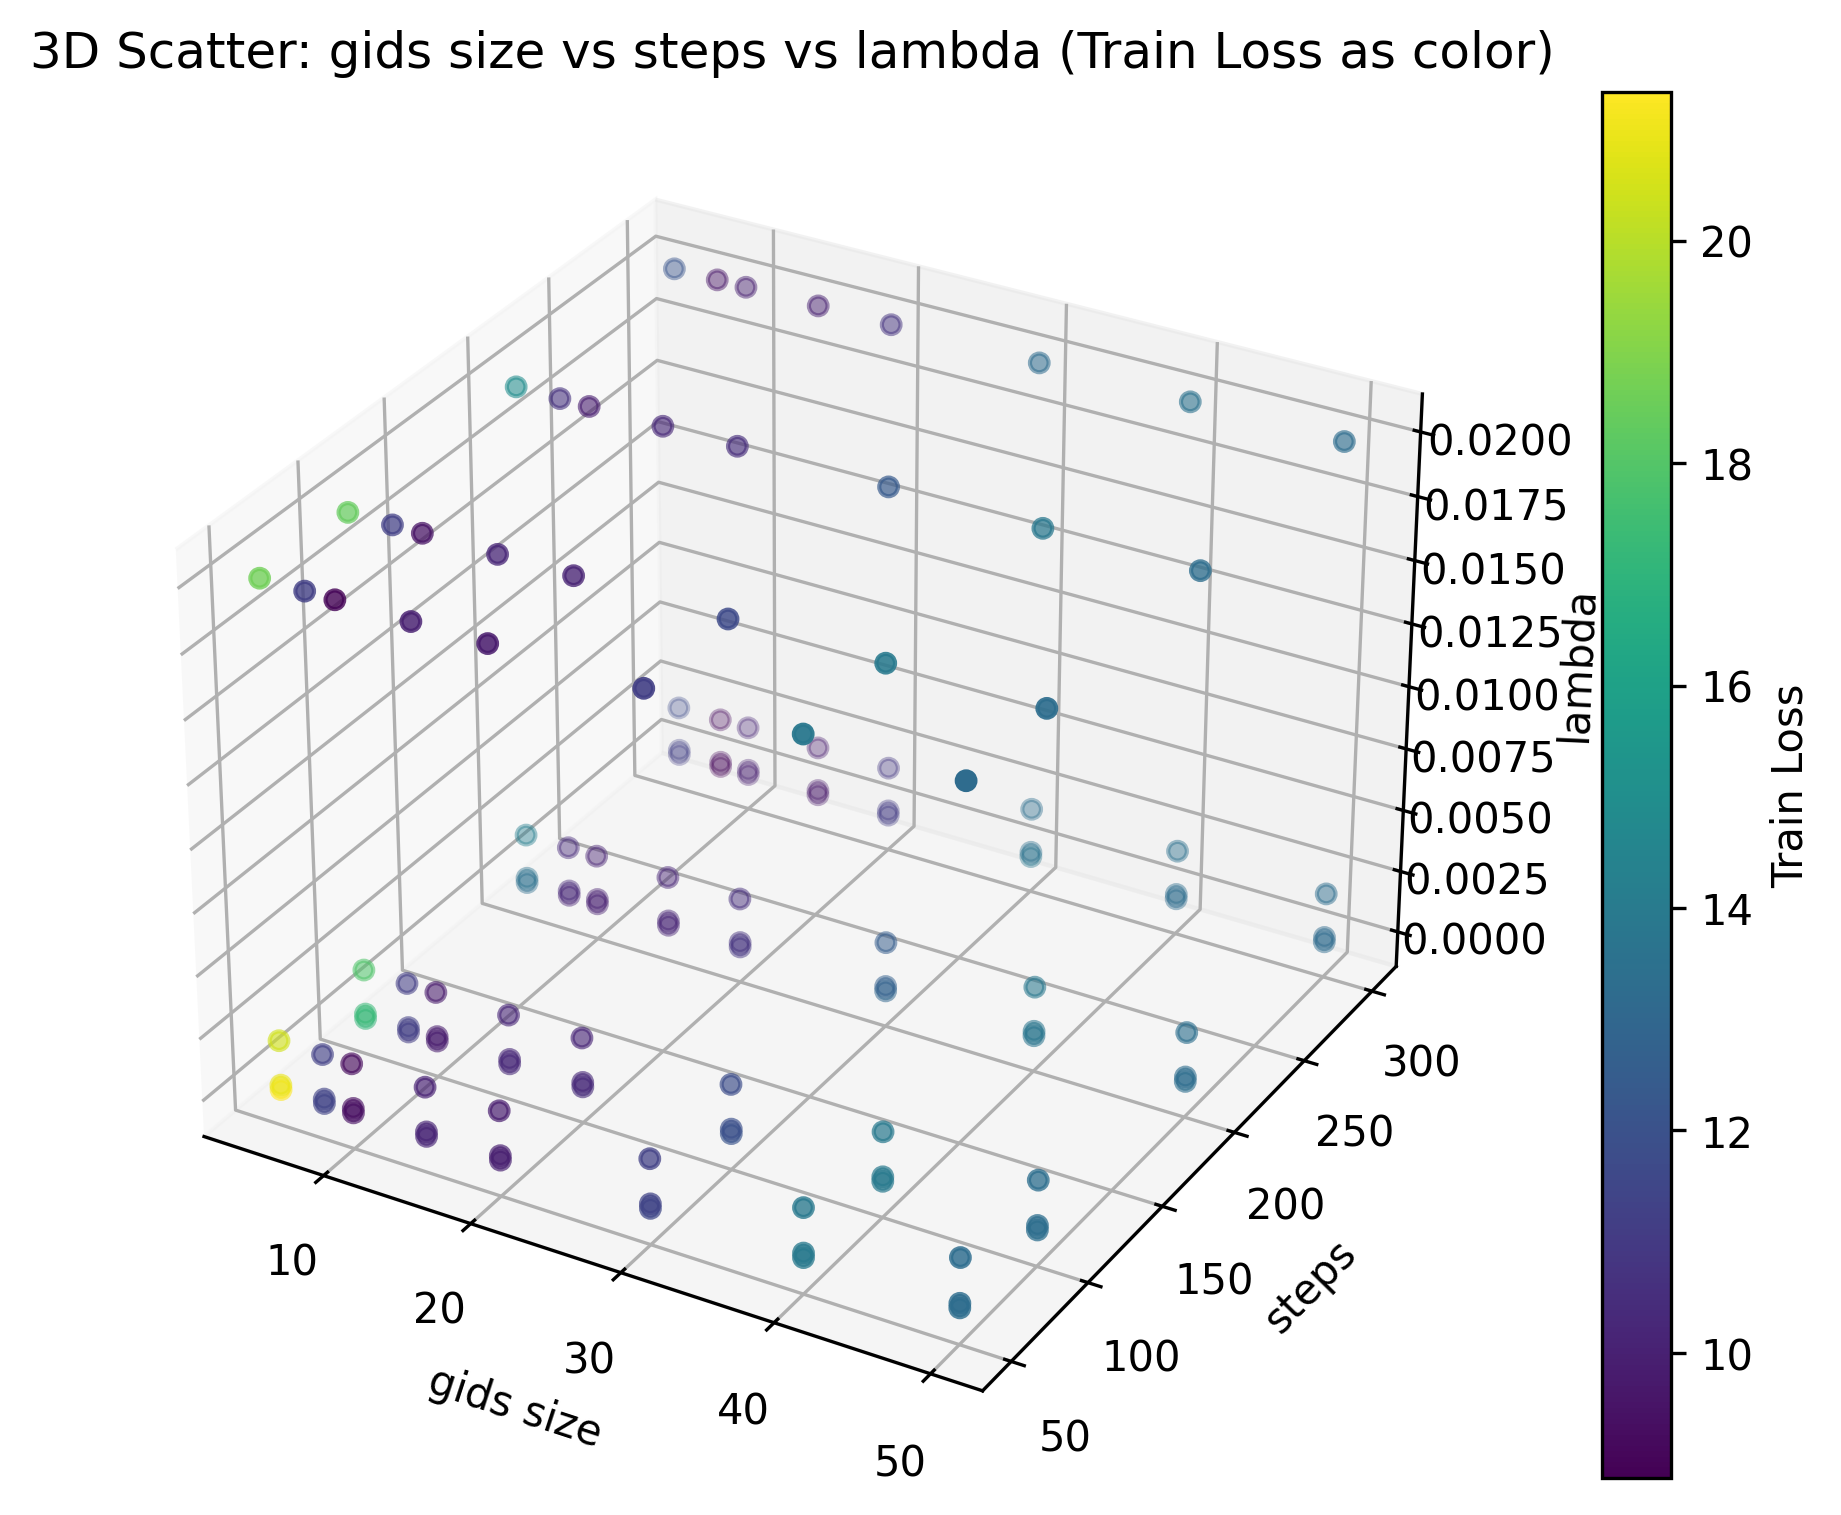

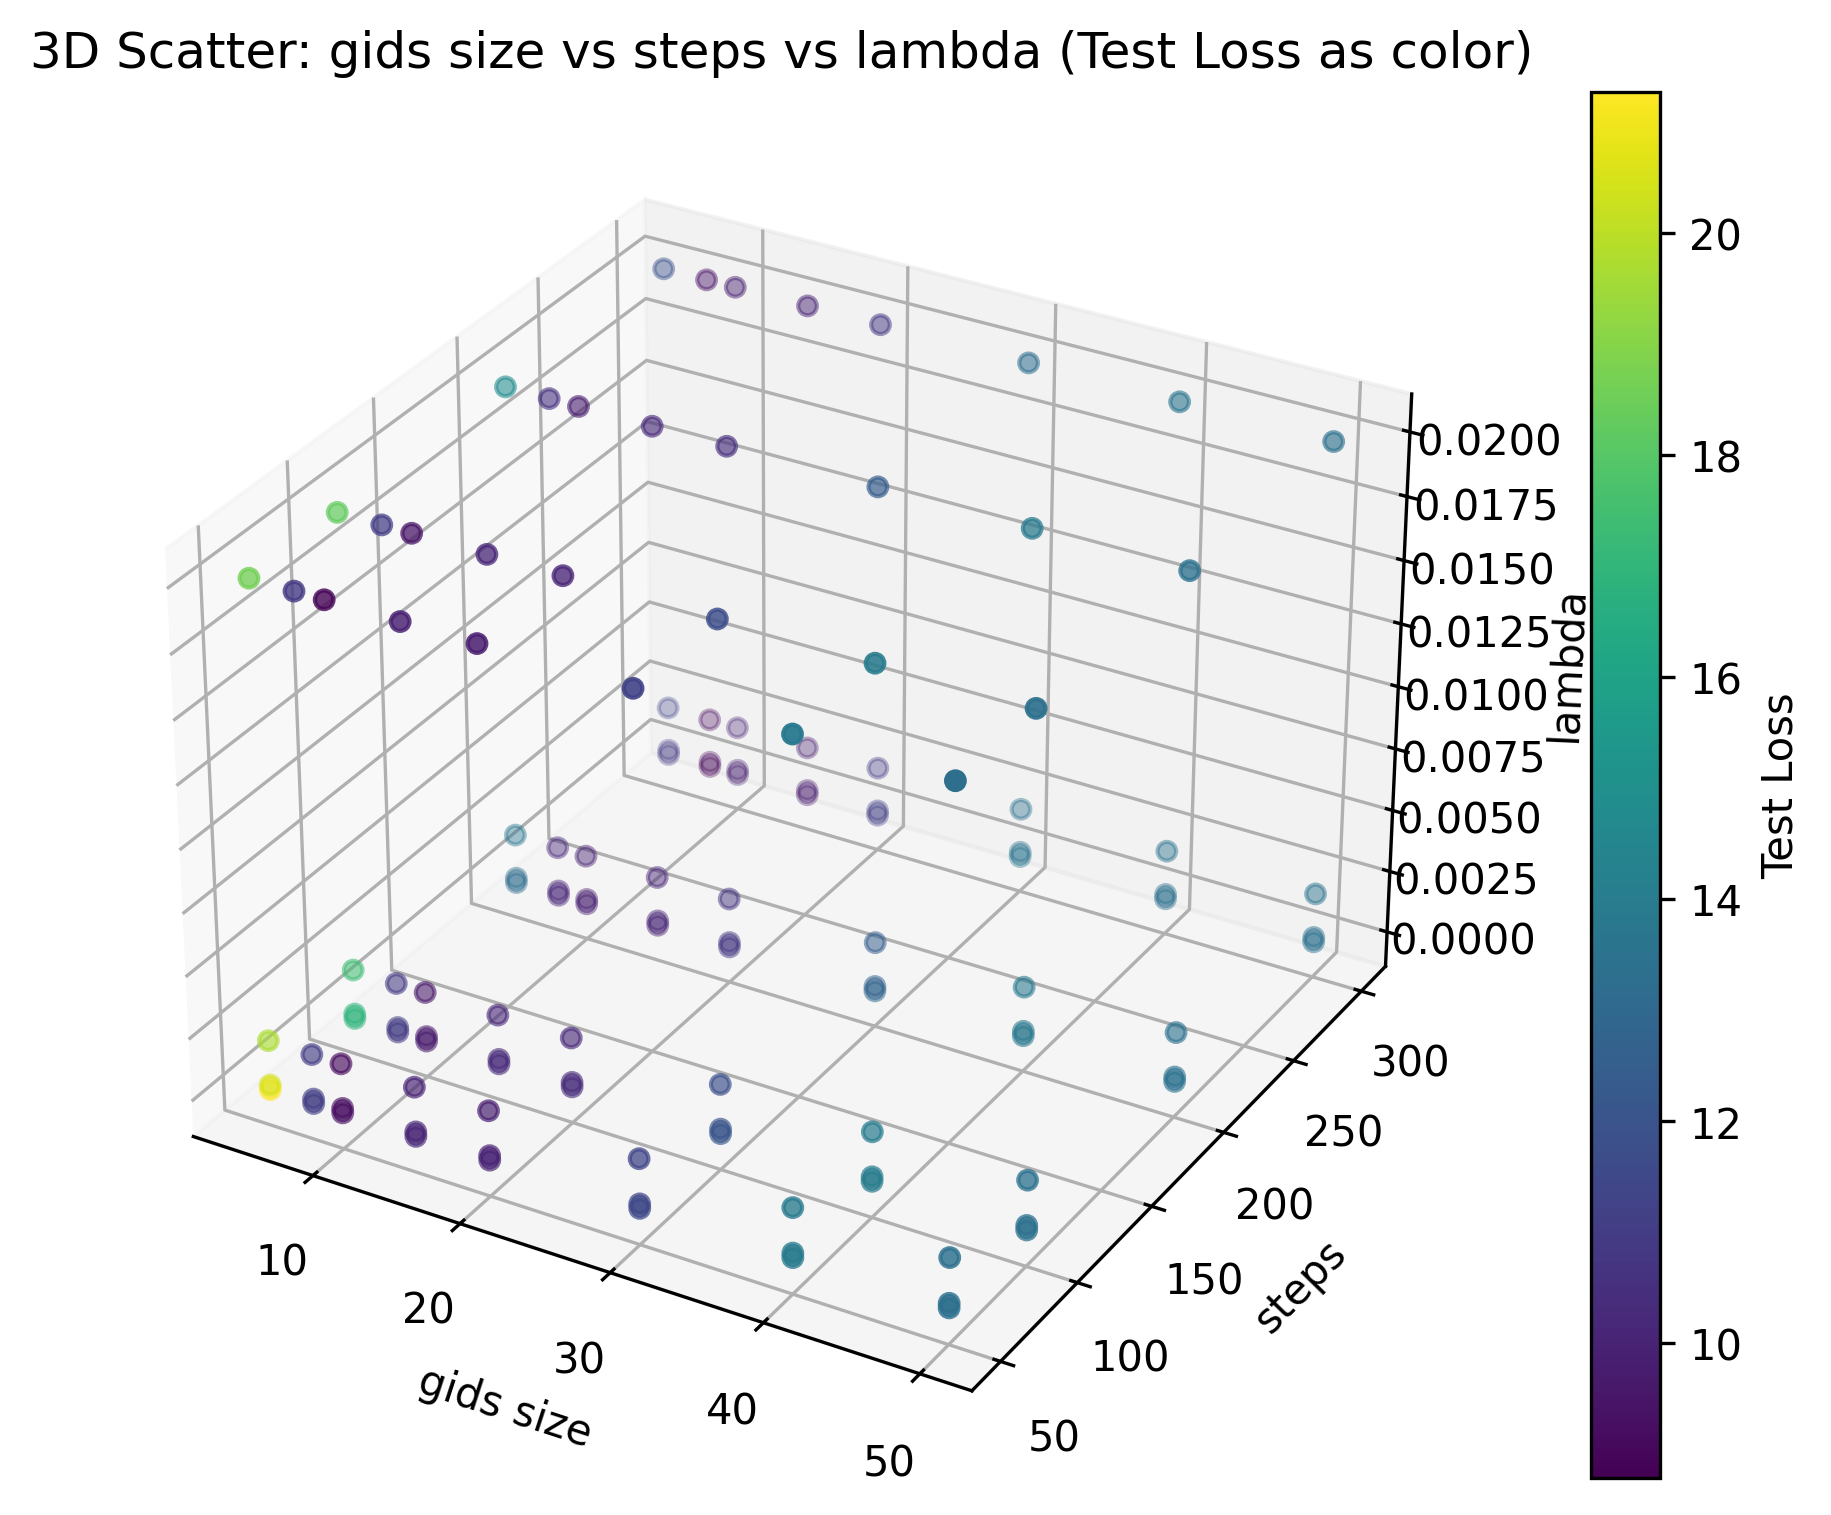

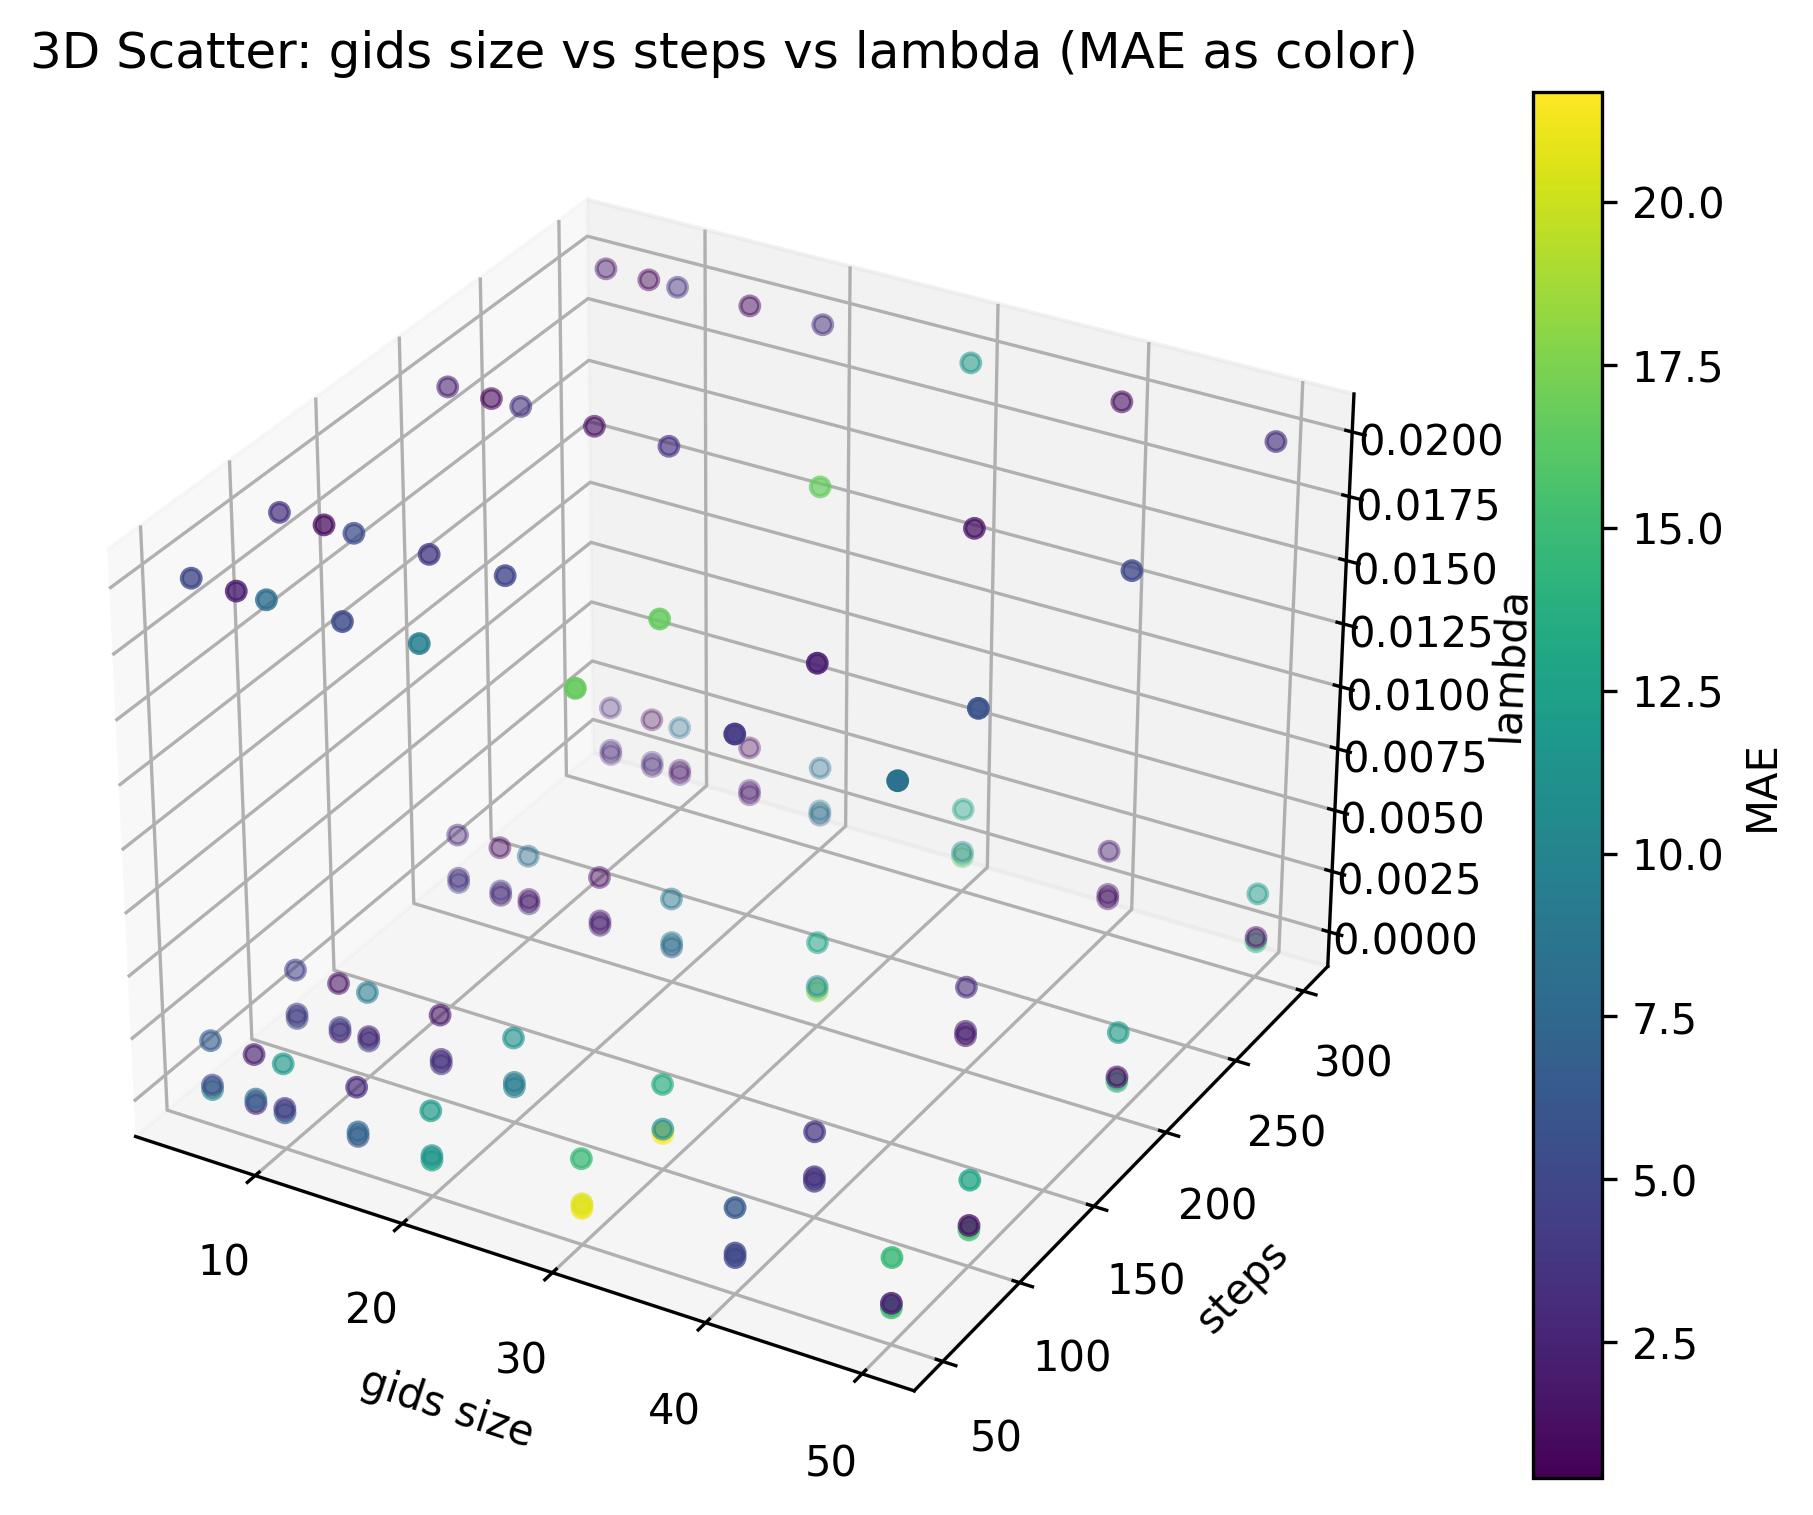

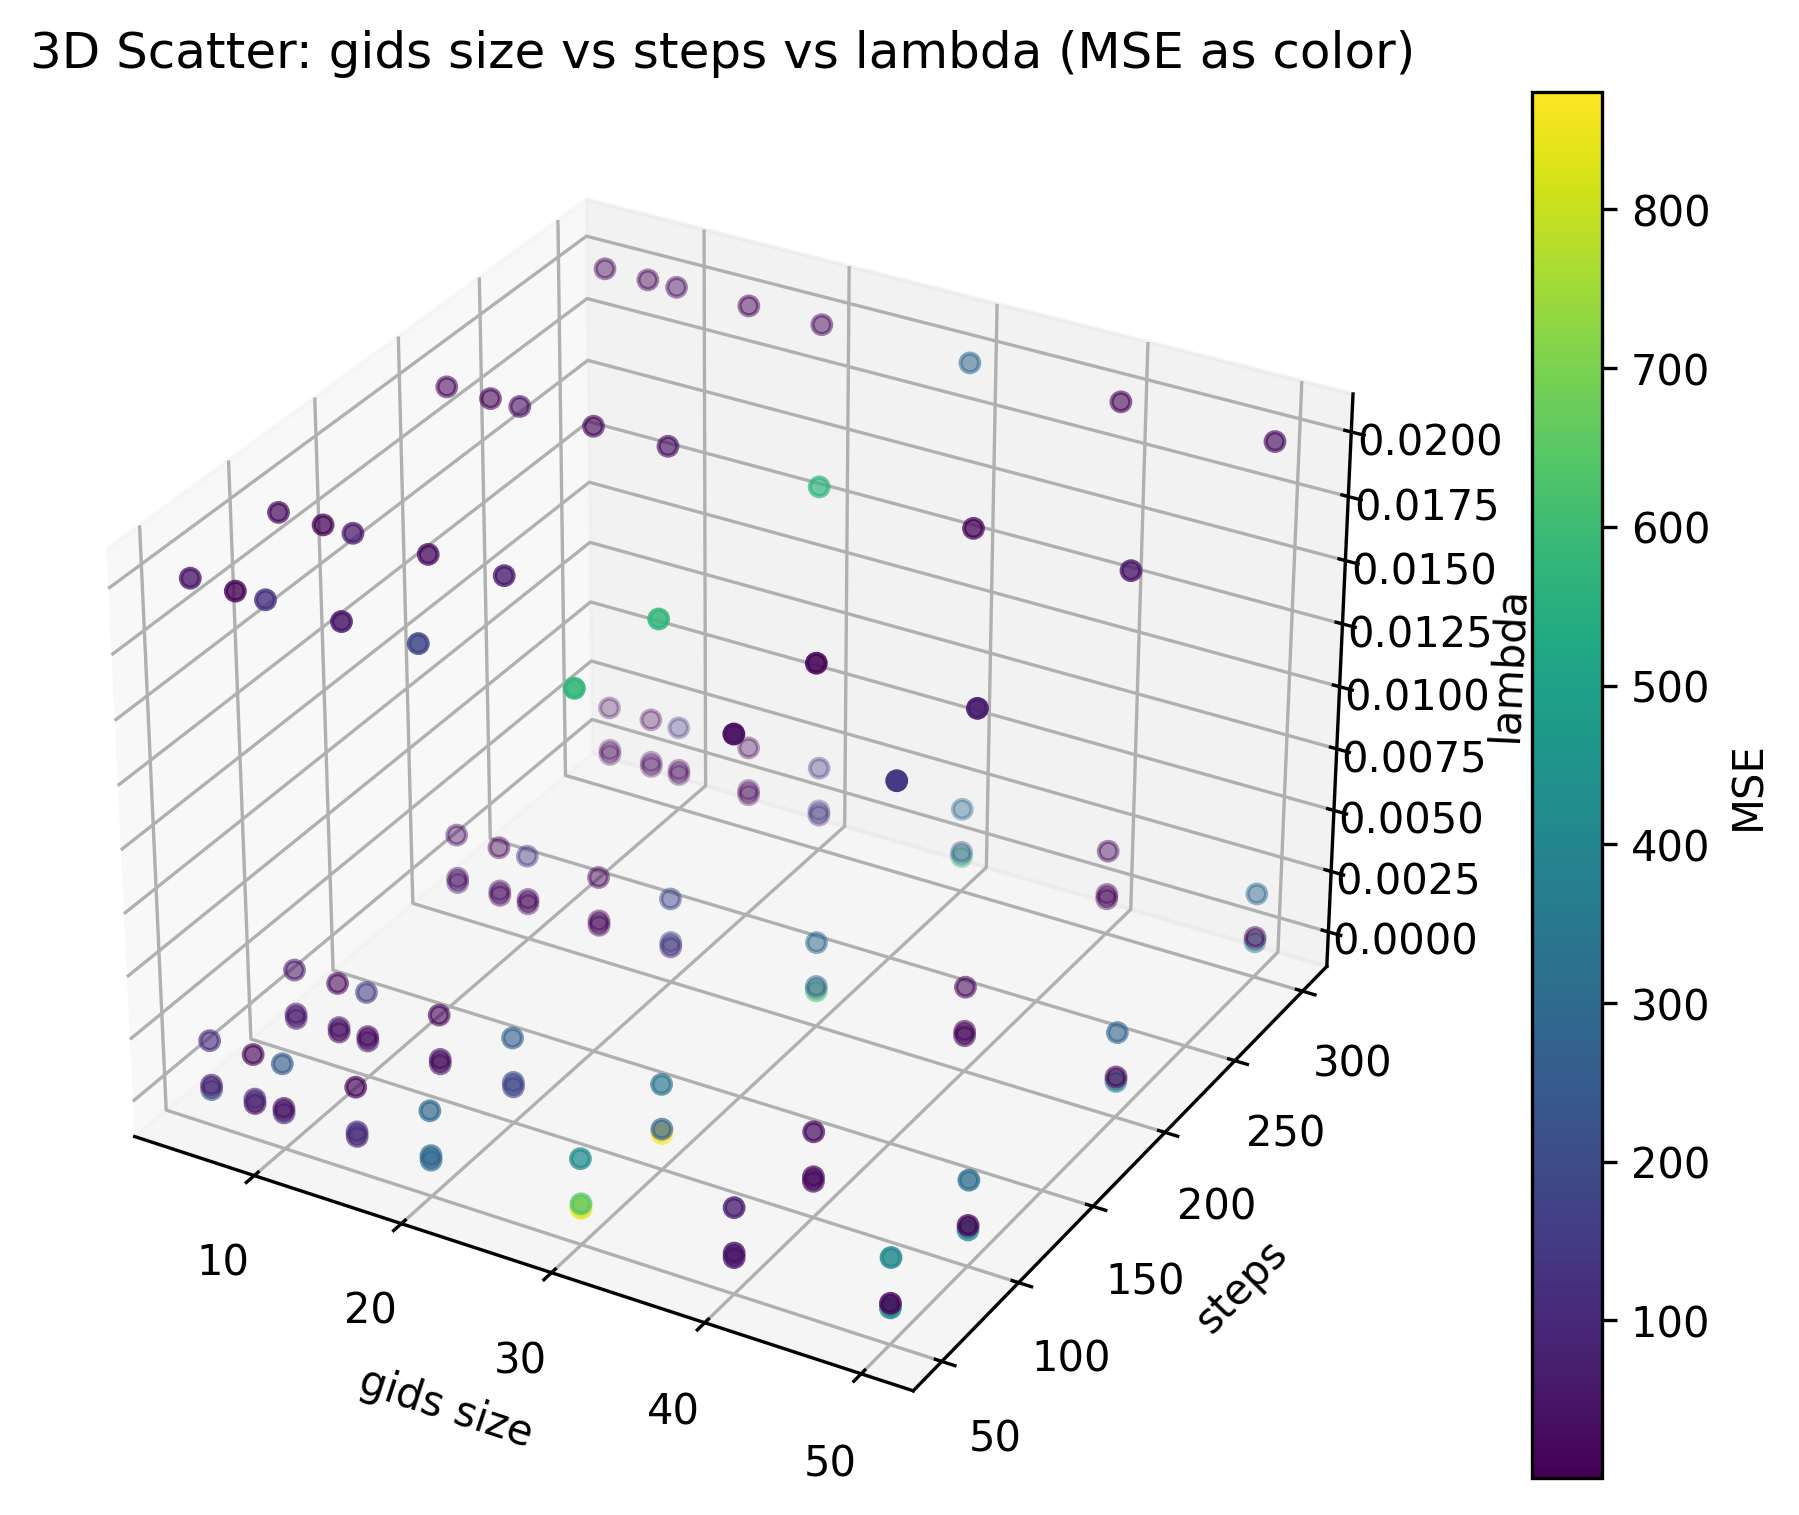

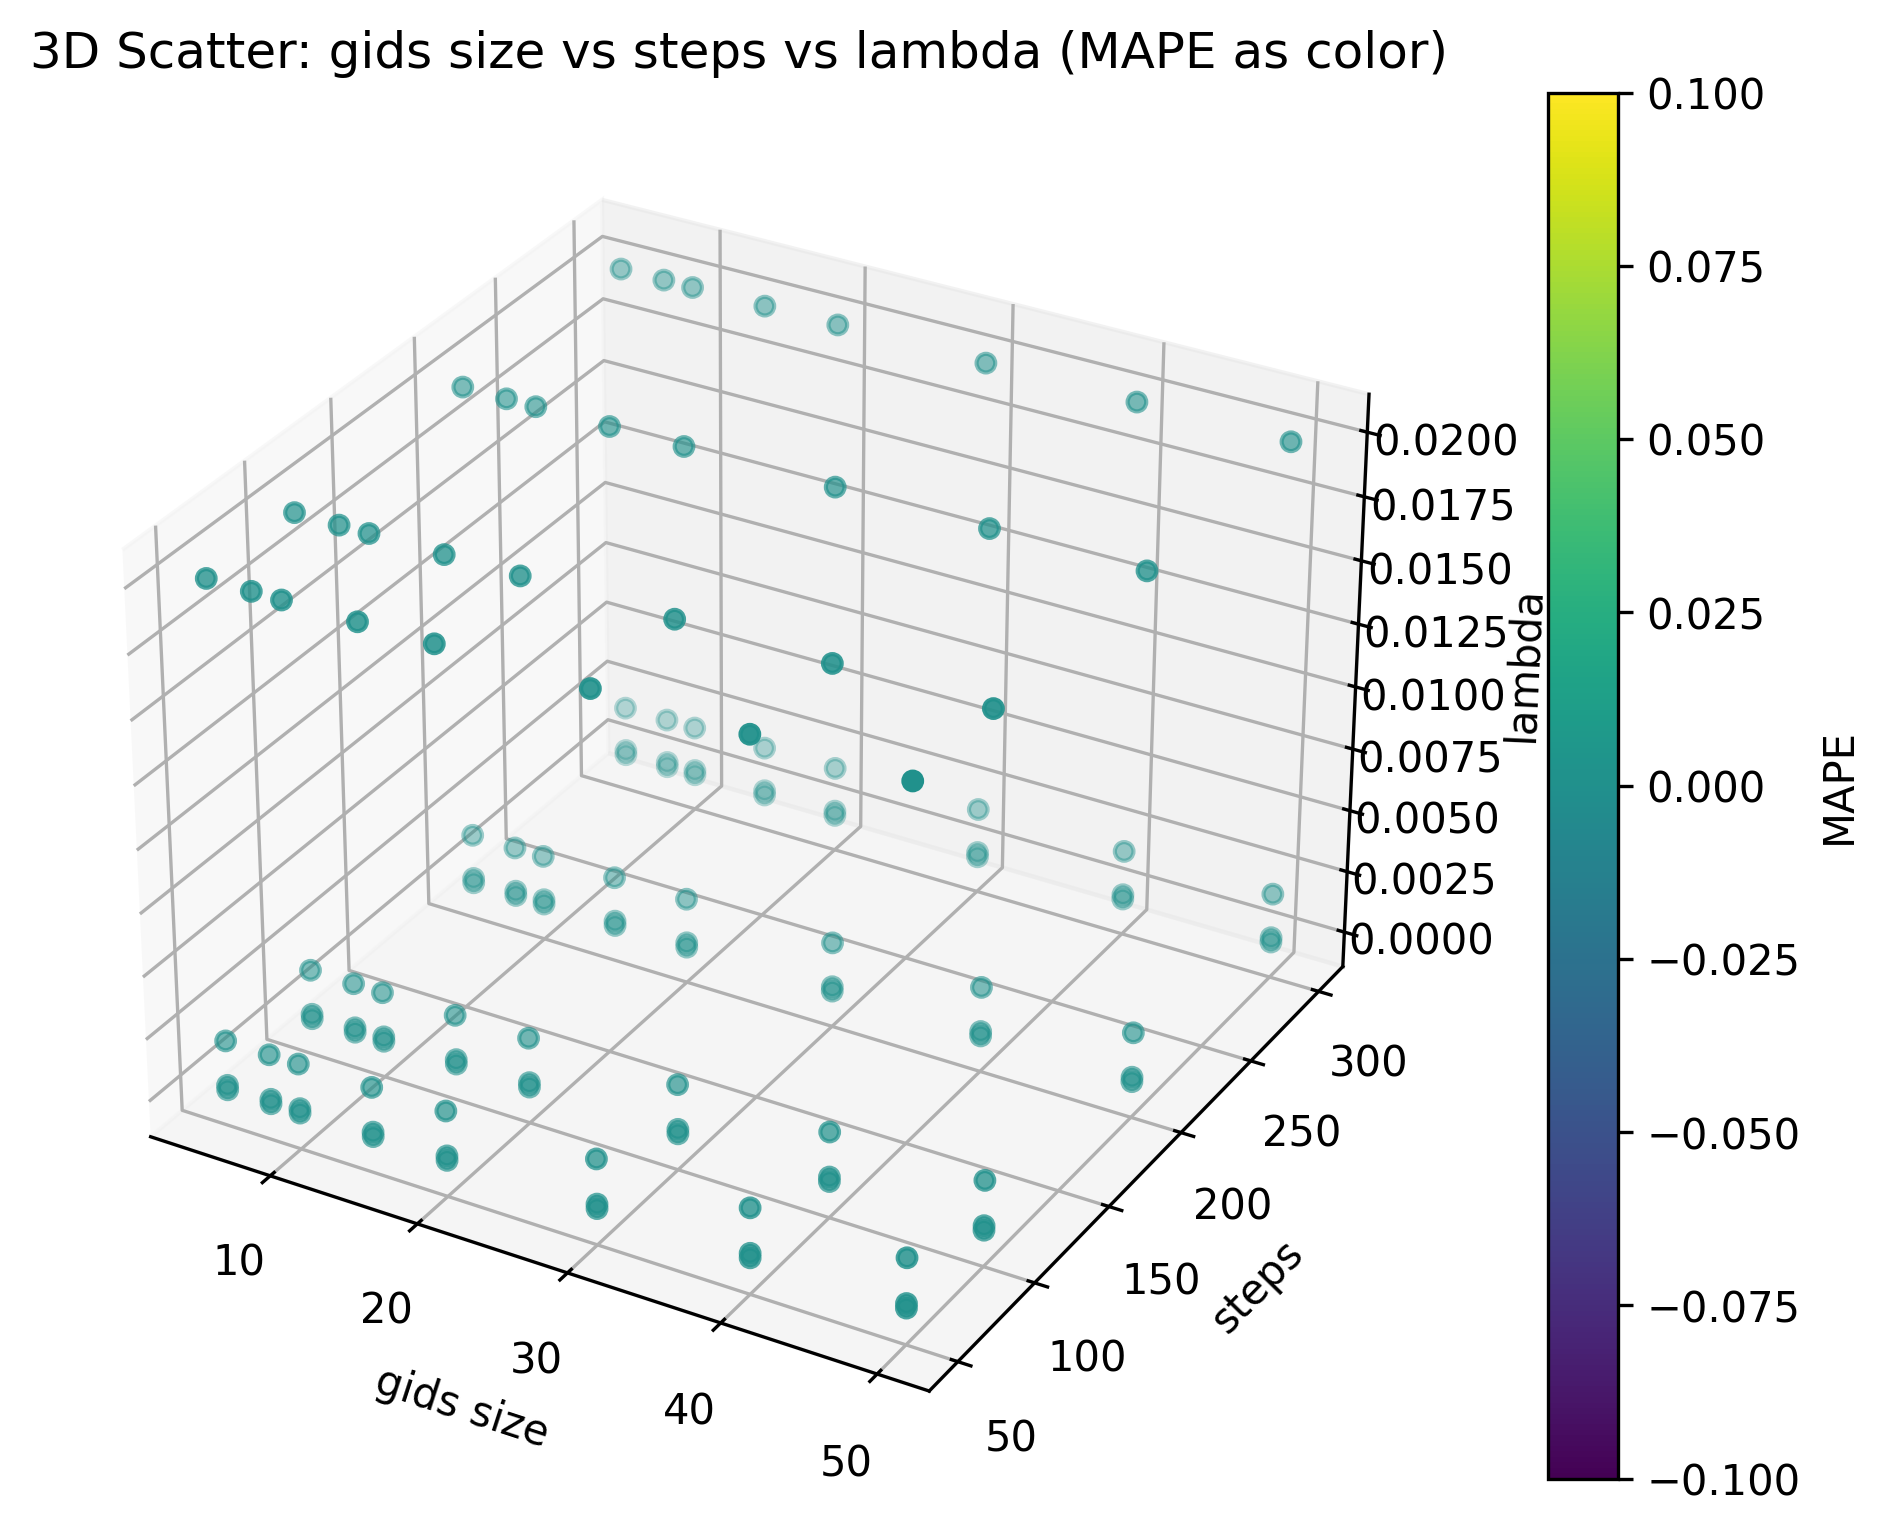

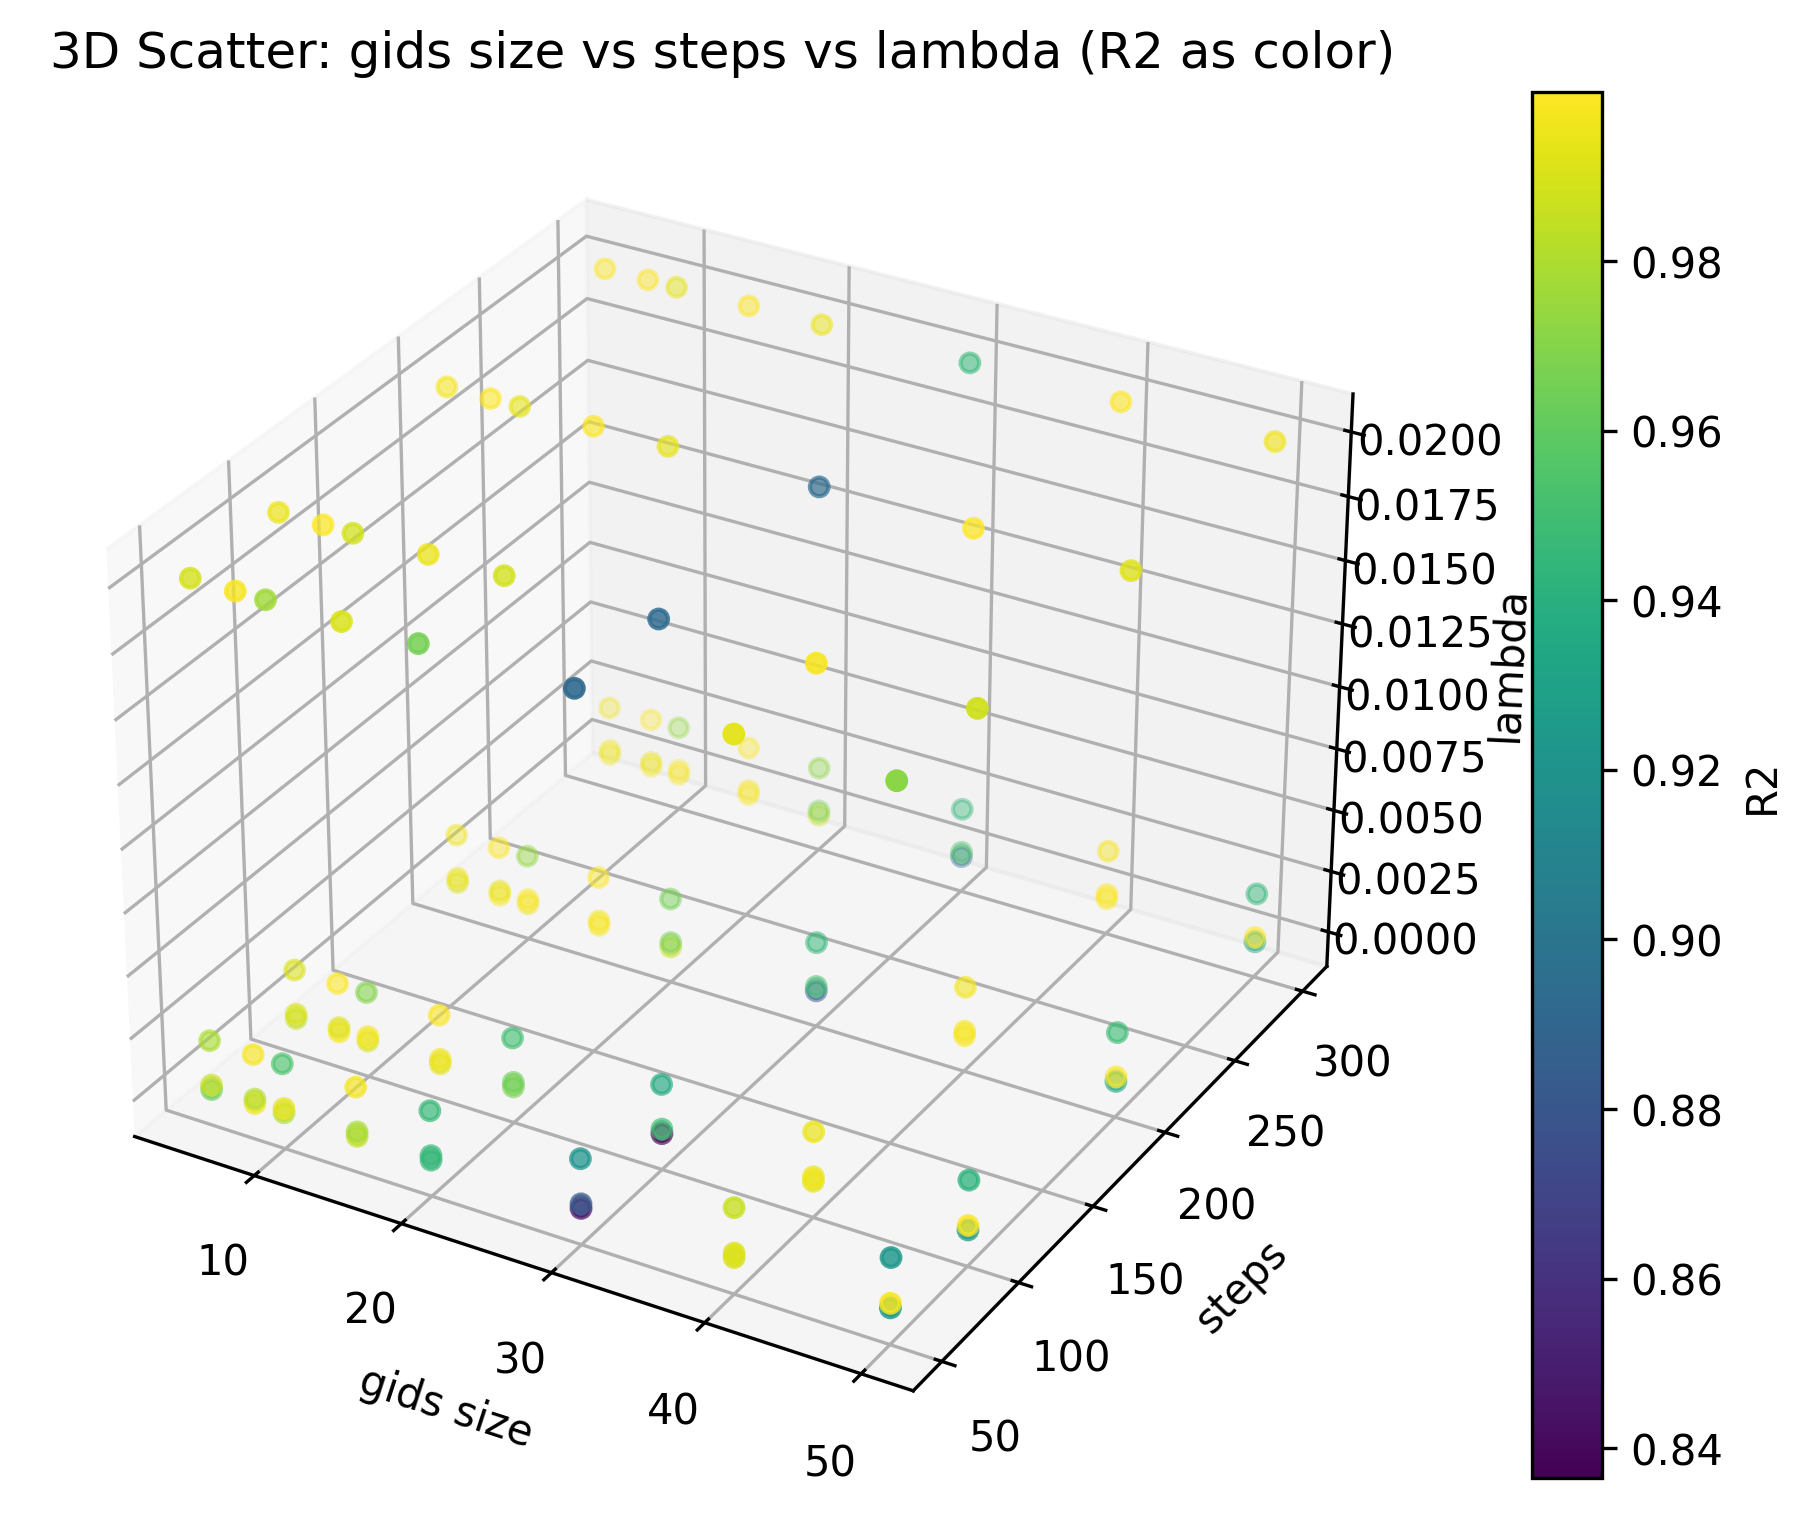

In [16]:
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_losses, "Train Loss")
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, te_losses, 'Test Loss')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_maes, 'MAE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mses, 'MSE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mapes, 'MAPE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_r2s, 'R2')

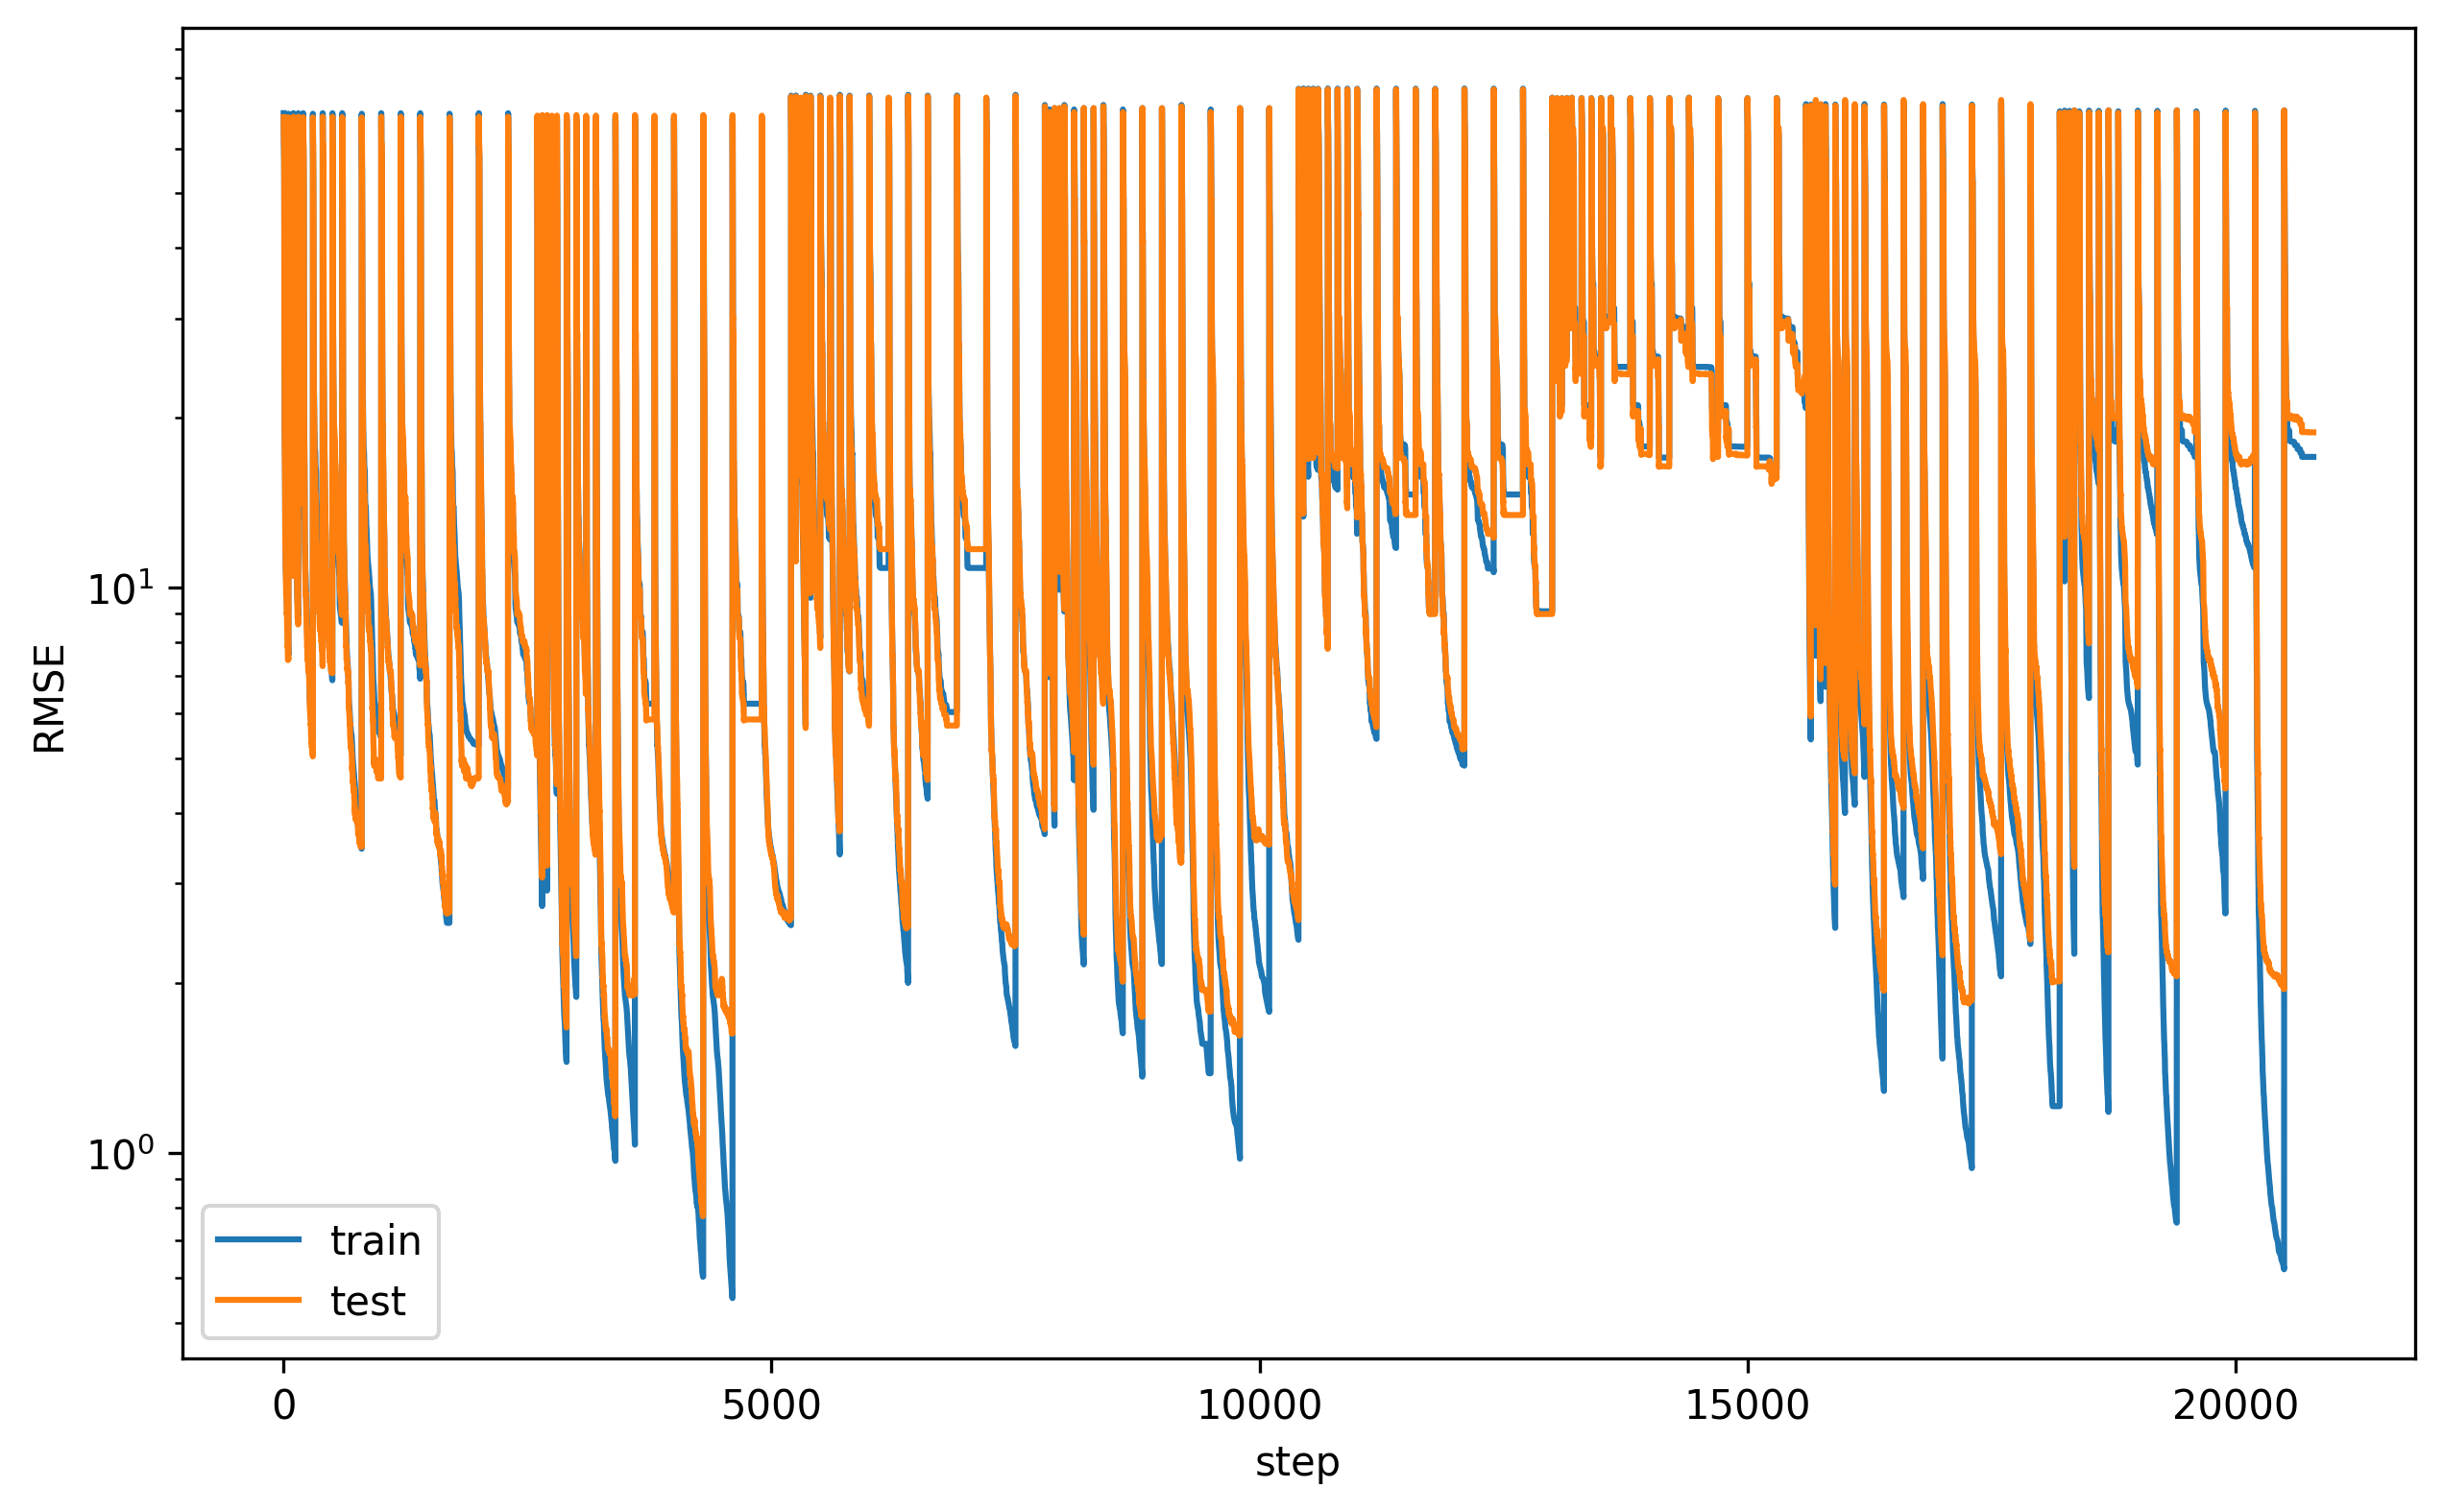

In [12]:
# Plot the training and test losses.
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e+00 | test_loss: 1.67e+00 | reg: 1.33e+02 | : 100%|█| 100/100 [00:12<00:00,  7.98


saving model version 0.1
fixing (0,0,0) with exp, r2=0.9901150465011597, c=2
fixing (0,0,1) with x, r2=0.999987781047821, c=1
fixing (0,0,2) with x, r2=0.9965242743492126, c=1
fixing (0,0,3) with x, r2=0.968700110912323, c=1
fixing (0,1,0) with x, r2=0.9902373552322388, c=1
fixing (0,1,1) with x, r2=0.998756468296051, c=1
fixing (0,1,2) with x, r2=0.9934782385826111, c=1
fixing (0,1,3) with x, r2=0.9908829927444458, c=1
fixing (0,2,0) with x, r2=0.9662975072860718, c=1
fixing (0,2,1) with x, r2=1.0000003576278687, c=1
fixing (0,2,2) with x, r2=0.9935135245323181, c=1
fixing (0,2,3) with x, r2=1.000000238418579, c=1
fixing (0,3,0) with x, r2=0.773252546787262, c=1
fixing (0,3,1) with x, r2=0.9999545216560364, c=1
fixing (0,3,2) with x, r2=0.580936849117279, c=1
fixing (0,3,3) with x, r2=0.5879270434379578, c=1
fixing (1,0,0) with x, r2=0.996111273765564, c=1
fixing (1,1,0) with x, r2=0.4330796003341675, c=1
fixing (1,2,0) with x, r2=0.9789531230926514, c=1
fixing (1,3,0) with x, r2=0.05

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:18<00:00,  5.37it/s]


saving model version 0.3


ValueError: Input contains NaN.

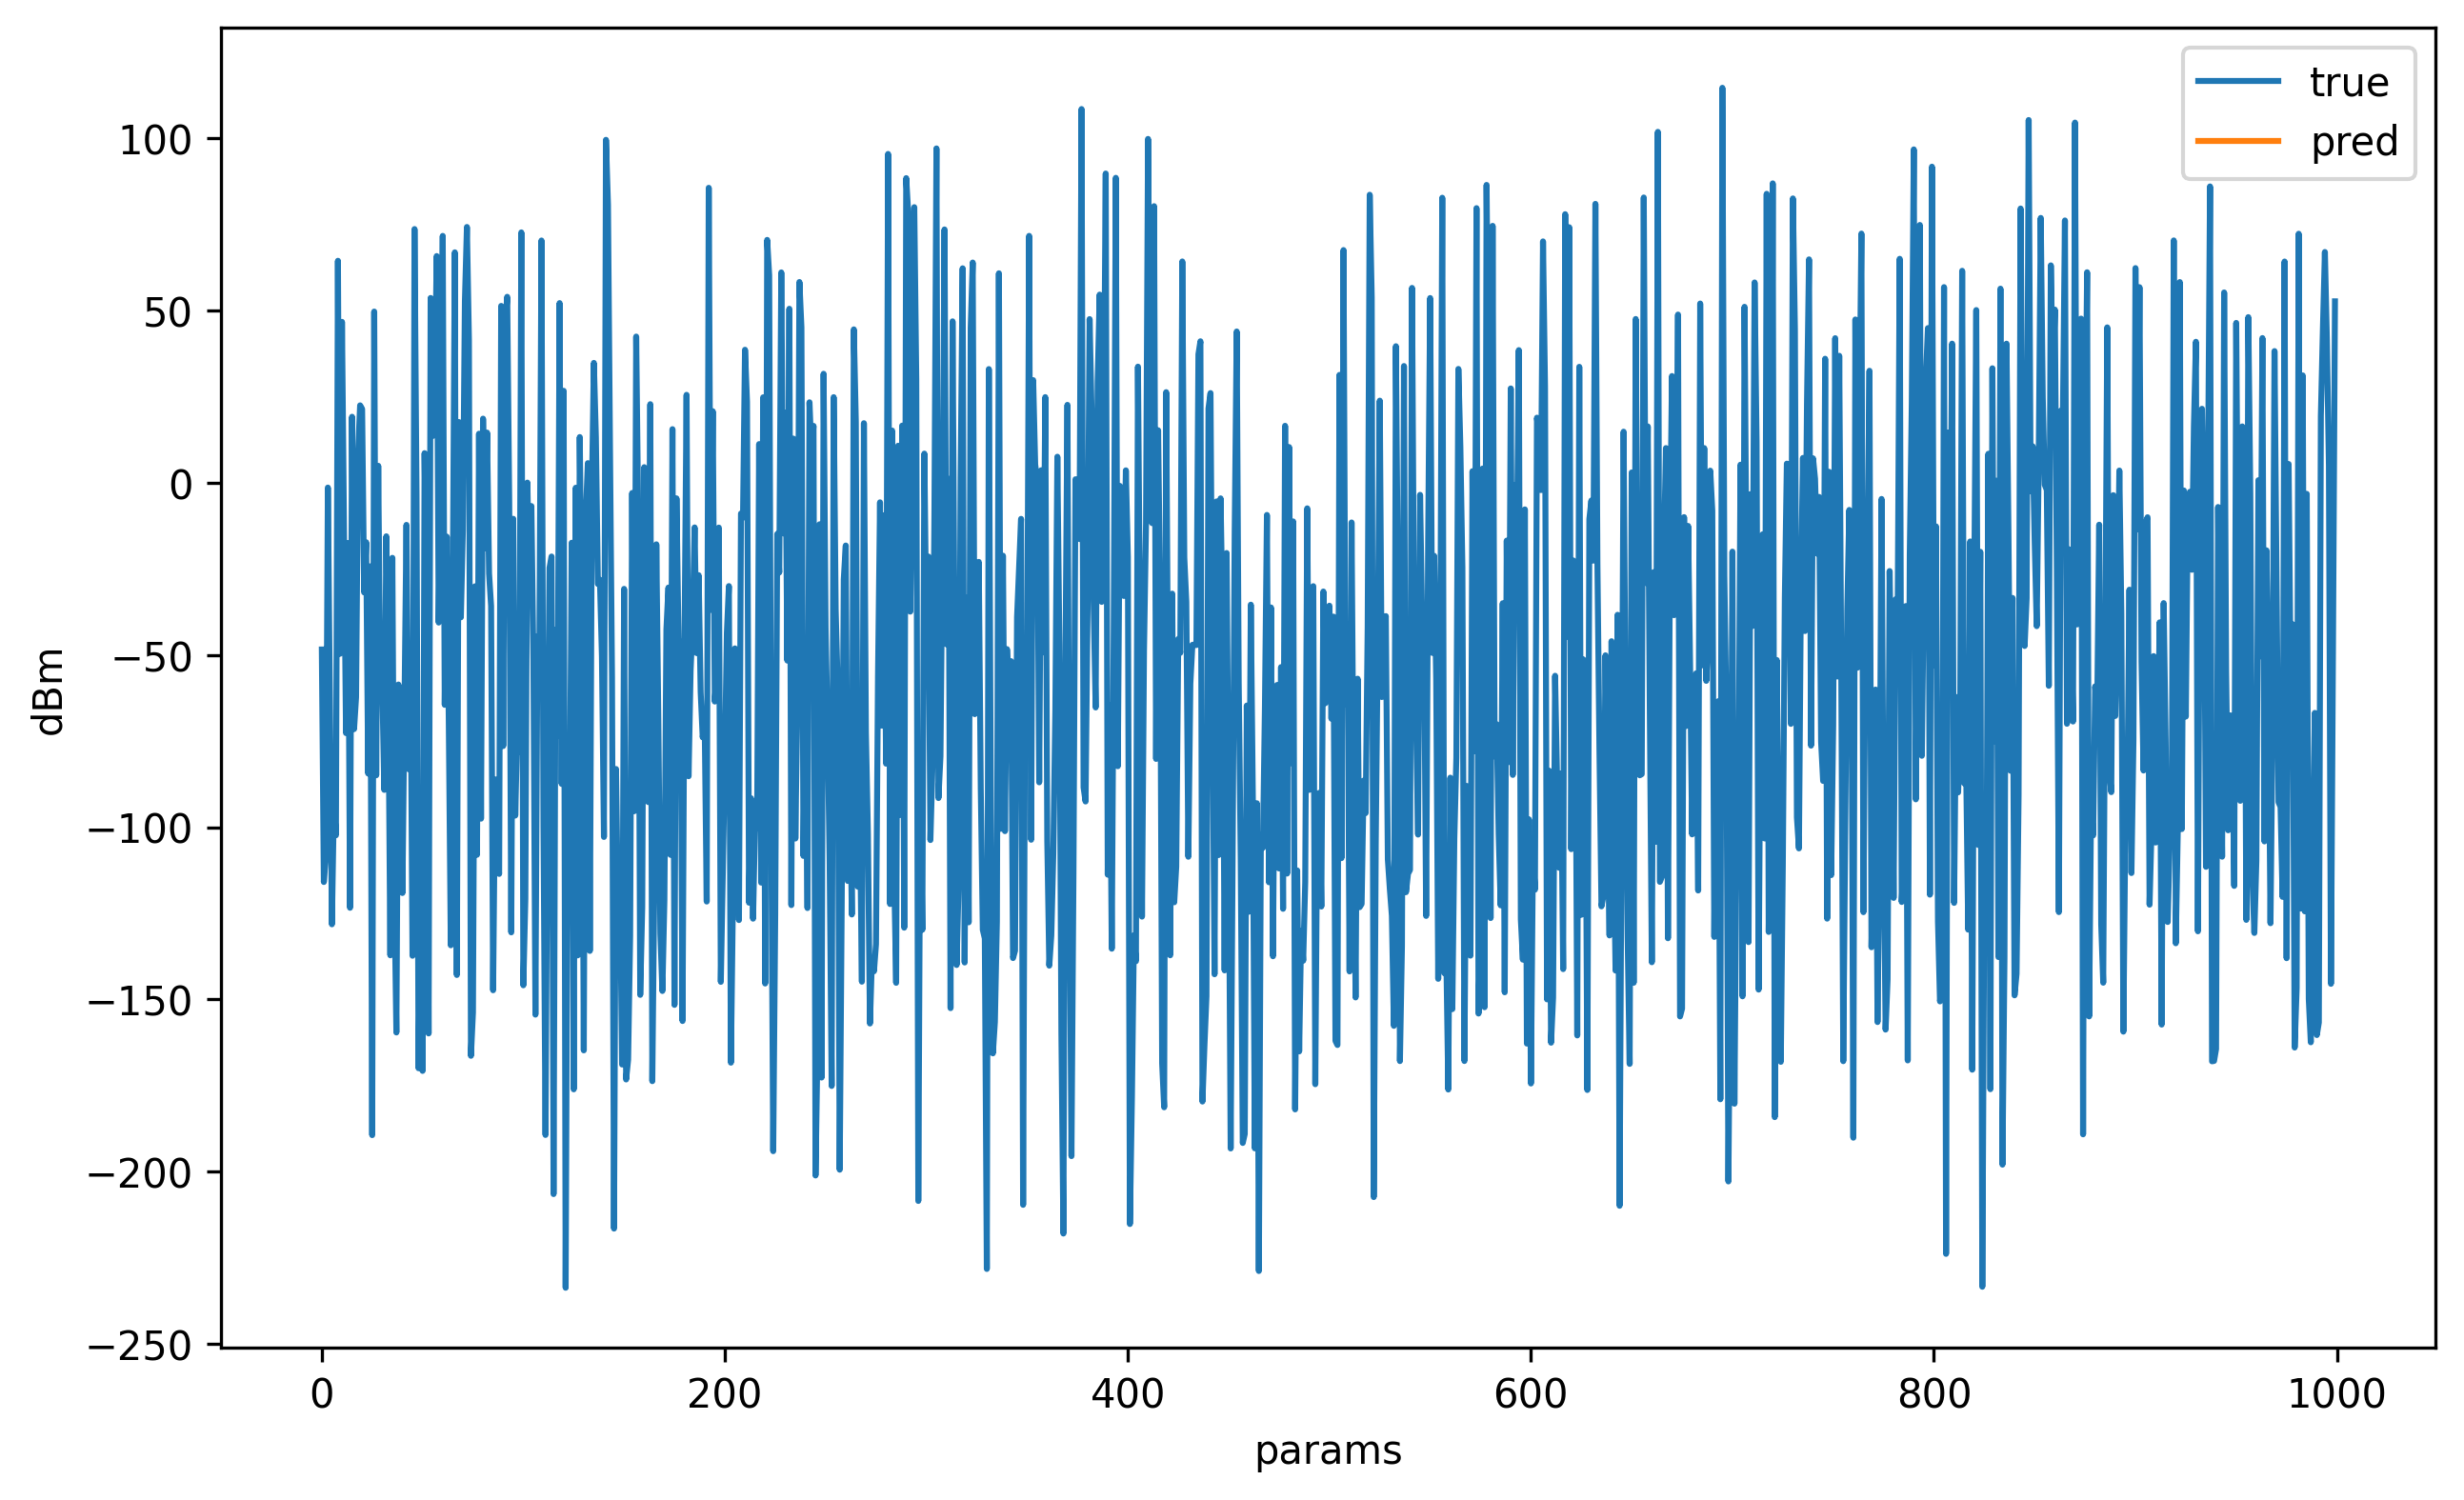

In [37]:
model = KAN(width=[4,4,1], grid=8, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);

lib = ['x', 'log', 'exp', 'sqrt', 'abs']
model.auto_symbolic(lib=lib)

# model.suggest_symbolic(0,0,0)
# model.suggest_symbolic(0,0,1)
# model.suggest_symbolic(0,0,2)
# model.suggest_symbolic(0,0,3) 
# model.suggest_symbolic(0,1,0) 
# model.suggest_symbolic(0,1,1) 

# model.fix_symbolic(0,0,0,'1/x^2')
# model.fix_symbolic(0,0,0,'x')
# model.fix_symbolic(0,0,0,'exp')
# model.fix_symbolic(0,0,0,'x')
# model.fix_symbolic(0,0,0,'sin')

# model.fix_symbolic(0,1,2,'x')
# model.fix_symbolic(0,1,3,'x') 
# model.fix_symbolic(0,2,0,'sqrt')
# model.fix_symbolic(0,2,1,'x') 
# model.fix_symbolic(0,2,2, 'log')
# model.fix_symbolic(0,2,3, 'x')

# model.suggest_symbolic(0,1,2)
# model.suggest_symbolic(0,1,3) 
# model.suggest_symbolic(0,2,0)
# model.suggest_symbolic(0,2,1) 
# model.suggest_symbolic(0,2,2)
# model.suggest_symbolic(0,2,3)
# #fixing (0,3,0) with 0, r2=0.0, c=0
# model.suggest_symbolic(0,3,1) 
# model.suggest_symbolic(0,3,2) 
# model.suggest_symbolic(0,3,3) 
# model.suggest_symbolic(1,0,0) 
# model.suggest_symbolic(1,1,0) 
# model.suggest_symbolic(1,2,0) 
# model.suggest_symbolic(1,3,0)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);
eval_kan(model, dataset)



    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0          x    0.997019 -8.384980           1                1   -0.876996
1      x^0.5    0.997166 -8.457640           2                2   -0.091528
2       sqrt    0.997166 -8.457640           2                2   -0.091528
3        log    0.997164 -8.456884           2                2   -0.091377
4  1/sqrt(x)    0.997164 -8.456673           2                2   -0.091335
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        x    0.993790 -7.328863           1                1   -0.665773
1      cos    0.998800 -9.690469           2                2   -0.338094
2      sin    0.998800 -9.690469           2                2   -0.338094
3      x^2    0.997506 -8.641391           2                2   -0.128278
4      exp    0.997334 -8.545547           2                2   -0.109109
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0    x^0.5    0.998796 -9.

('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(1.000000238418579),
 np.int64(1))

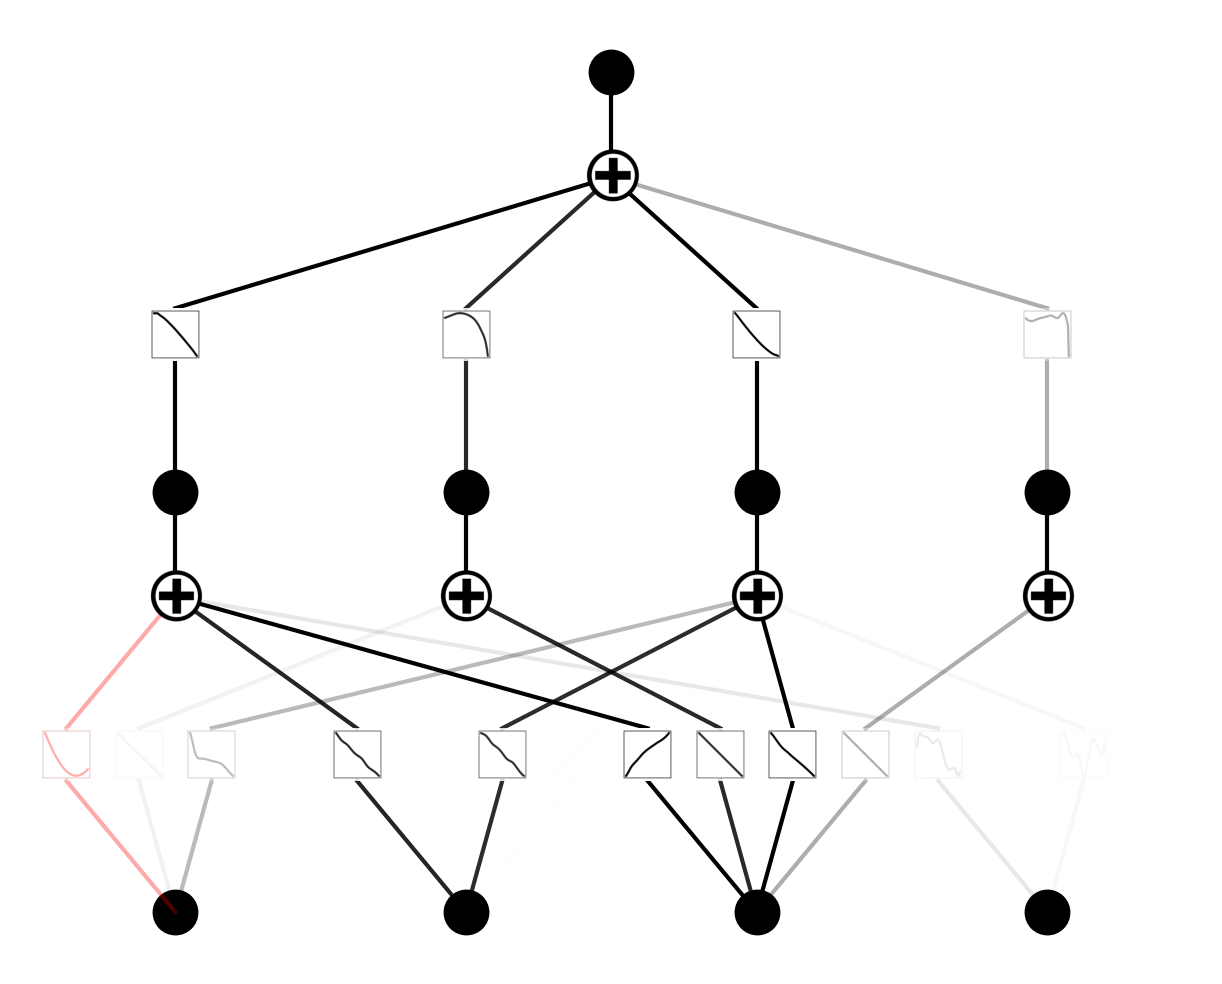

In [33]:
model.plot()

model.suggest_symbolic(0,1,2)
model.suggest_symbolic(0,1,3) 
model.suggest_symbolic(0,2,0)
model.suggest_symbolic(0,2,1) 
model.suggest_symbolic(0,2,2)
model.suggest_symbolic(0,2,3)



r2 is 0.9970186352729797
saving model version 0.8
r2 is 0.9937899708747864
saving model version 0.9
r2 is 0.9987955093383789
saving model version 0.10
r2 is 1.000000238418579
saving model version 0.11
r2 is 0.997937798500061
saving model version 0.12
r2 is 1.000000238418579
saving model version 0.13


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:18<00:00,  5.36it/s]


saving model version 0.14


ValueError: Input contains NaN.

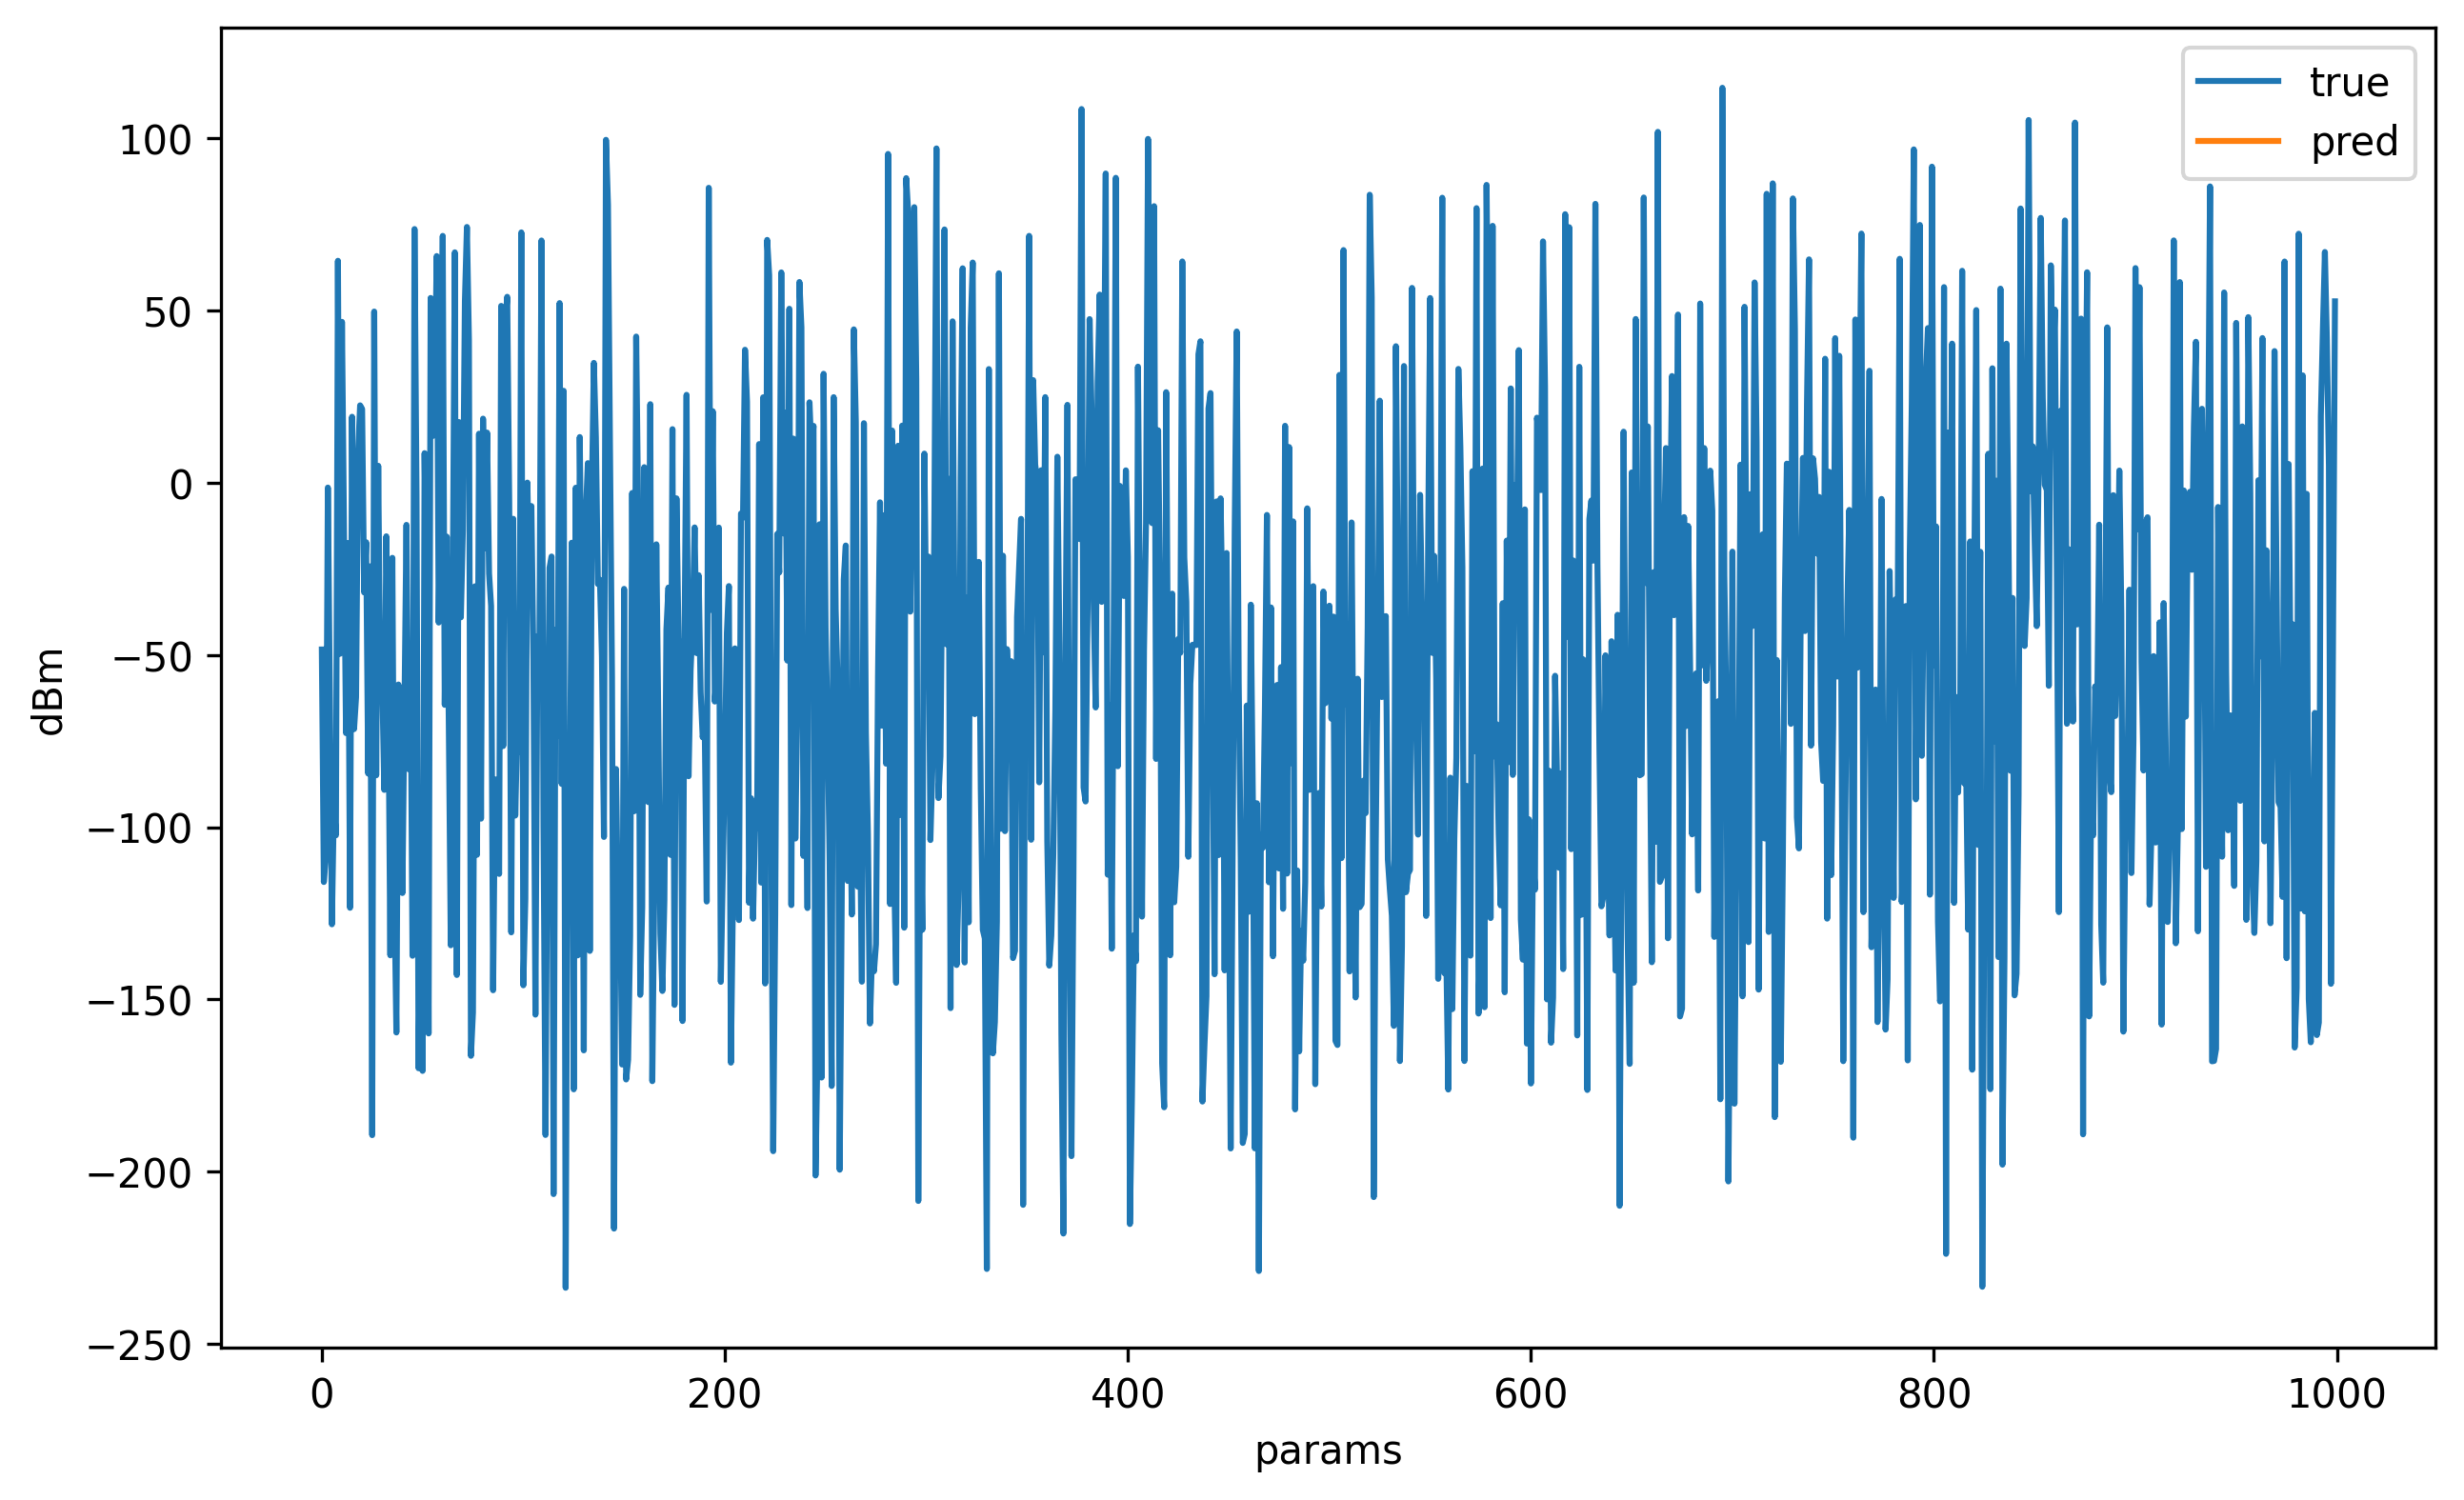

In [35]:
model.fix_symbolic(0,1,2,'x')
model.fix_symbolic(0,1,3,'x') 
model.fix_symbolic(0,2,0,'sqrt')
model.fix_symbolic(0,2,1,'x') 
model.fix_symbolic(0,2,2, 'log')
model.fix_symbolic(0,2,3, 'x')

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);
eval_kan(model, dataset)

model.plot()

formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))